# Assignment 5 — Final Project Preparation



### Goal
This assignment prepares you for your *final group presentation*.

Here is what the final project will look like:
- You will choose **one partner** in the class.  
- Together, you will give a **15-minute presentation** (including Q&A) on **any chemistry topic** on December 2 or 4.  
- Your presentation should include:
  - **Background information** on your topic  
  - **Identification of a challenge or problem**  
  - **Proposed solution or approach**

Your topic can be **similar or different** from your midterm review.

### Code Component
As part of your final project, you must include a *code demonstration*.  
This code does *not* need to be comprehensive, but it should show:

- How you **approach** your chosen problem  
- What methods or models you use  
- **Some results**, such as:
  - Accuracy or performance metrics (even if poor)
  - Dataset size or example data
  - Plots and visualizations showing before and after machine learning

You may use **dummy data**, **typed data**, or **data from literature**.  
The main requirement is that your code **runs successfully** and helps you explain your idea during the presentation. Your output for this assignment should look quite similar to the many case studies we have covered in the class.

---

### What to Submit for Assignment 5
This assignment is a *practice stage* for your final project. You will fill in the following:

1. **Tentative Topic** – What chemistry topic you plan to explore  
2. **Challenge** – The key problem you want to solve  
3. **Inputs and Outputs** – What goes into your model and what you expect to get out  
4. **Tentative Approach** – The model or method you’ll explore  
5. **Evaluation Method** – How you’ll check your model or analysis

You can use **dummy data** or **small dataset** at this stage, as long as your code is **executable** and demonstrates a **proof of concept**. Do not worry about the accuracy.

---

### Group Work
- Each group will have **two students** (in rare case, three students, with the permission from the instructor).  
- You can use: https://docs.google.com/document/d/13q21lpcjc1jcU3FSaWJaKAo8WAqIwrCPhRPCqQ4n-mM/edit?usp=sharing to indicate you sign up with someone in the class. If you can not find a partner, email the instructor by Nov. 20th and you will be assigned one.
- Both partners submit the **same file**, but you are encouraged to **split the work** into two related parts.  
  - Example 1: one student handles **data preprocessing**, the other **model training**.  
  - Example 2: one student handles **surpervised learning apparoch**, the other try **generative modeling**.  
  - This gives you **more** plots and code to show during the final presentation.

---

### Code Requirements
- At least 150 lines / 10 cells and 3 plots are required (actually, this is pretty much the similar length as your previous assignments).  
- It's encouraged to create more plots if possible, which will make your presentation much easier.
- You may use ChatGPT to help generate or refine your code. However, you must ensure:
  - The **code runs correctly** without errors.  
  - The **code is relevant** to your chosen topic.  
  - It does **not appear as AI-generated filler**.  

If the code does **not run** or looks **unrelated**, you will receive **zero credit**.

---

### Grading
- While this assignment is graded on *completeness*, do keep in mind that your *final presentation* will be graded on:
  - Quality of explanation  
  - Relevance of the code  
  - Effectiveness of plots and visualizations  
So the more work you put in this assignment, the less preparation and higher score you have for your final!

---

### Deadline
**Due Date:** **November 30**

You will have plenty of time to form a group and plan your project.


----

Your Name:  Charlie Li


Your Group Partner's Name: Matthew Rao


Tentative Topic: Predicting protein residue crypticity and mechanistically understanding the factors influencing crypticity by assessing feature importance.

Definitions:
- ASA = Accessible Surface Area
- RSA = relative solvent accessibility = $\frac{ASA}{max(ASA)}\times 100\%$.
- Cryptic residue = sometimes exposed to solvent, sometimes buried inside
- Crypticity criteria: $max(RSA)>25$ && $min(RSA)<25$ && $max(RSA) - min(RSA) > 20$

Why do we care?
- Understand protein folding and dynamics
- Cryptic pockets are potential drug targets

Challenge:
* Crypticity is not well defined. We chose an operational definition, but different definitions could lead to different results.
* Crypticity is a dynamic property and depends both on the local and global environment. Static folding data or even dynamics data might be needed to predict crypticity.

Tentative Approach: We first encode the amino acid sequence of each gene with a transformer. This encoding is then blended into the encodings of protein names (which has categorical/functional information) produced by a trained llm, creating a fusion model. The final encoding is combined with other features and sent to multiple simpler models, whose performances are evaluated with F1 score.

Input: Protein global descriptors, residue chemical properties, residue modifications, residue evolutionary conservation, three experimental observations of RSA, and protein name and amino acid sequence.

Output: Crypticity at the given residue

Evaluation Method: F1 score, model coefficients or Gini index decrease for applicable models, attention maps for transformer, SHAP (Shapley Additive Explanations) for the final hybrid model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/chem-5080_final_project')
os.getcwd()

'/content/drive/MyDrive/chem-5080_final_project'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import_svc = False

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
if device == 'cuda' and import_svc:
  !pip install cudf-cu12==24.10.* cuml-cu12==24.10.* --extra-index-url=https://pypi.nvidia.com
  from cuml.svm import SVC
else:
  from sklearn.svm import SVC
import shap

# Pre-processing

**Raw data structure**:
 every row is for one residue on one site, per observation (identified by PDBID), per protein (identified by Gene_Name and Uniprot_Accession_ID). Each protein has various observations with different conformations, so each site in each protein will have multiple RSA values.

In [53]:
d = 'Int16'
num_comment = 14
newdtypes = {
  'Site' : 'int16', 'Amino_Acid':'object', 'Disordered': 'object',
  'Diff' : 'float32', 'High': 'float32','Low': 'float32',  'RSA' : 'float32',
  'Method':'category', 'PDBID':'object', 'Begin': d, 'End' : d,
  'Type': 'object', 'Comment' : 'object', "Length": 'float32',
  'From': 'object', 'Protein names':'object', 'Reviewed': 'category',
  'length': d, 'geneNamePrimary': 'object'
}
for i in range(2, num_comment) :
  num = str(i)
  newdtypes.update({'Begin'+num : d, 'End'+num : d, 'Type'+num:'object', 'Comment'+num:'object'})


In [54]:
start_time = time.time()
dataset = pd.concat([
  chunk for chunk in pd.read_csv(
    'pdb_rsa_raw_subset.csv',
    dtype=newdtypes,
    chunksize=5000
  )
], ignore_index=True)
stop_time = time.time()
print(f'runtime: {(stop_time-start_time)/60} minutes')

runtime: 0.9363157669703166 minutes


In [61]:
dataset.columns

Index(['Gene_Name', 'Uniprot_Accession_ID', 'Site', 'Amino_Acid', 'Disordered',
       'PDBID', 'Chain', 'RSA', 'Method', 'Mutation', 'Begin', 'End', 'Type',
       'Comment', 'Begin2', 'End2', 'Type2', 'Comment2', 'Begin3', 'End3',
       'Type3', 'Comment3', 'Begin4', 'End4', 'Type4', 'Comment4', 'Begin5',
       'End5', 'Type5', 'Comment5', 'Begin6', 'End6', 'Type6', 'Comment6',
       'Begin7', 'End7', 'Type7', 'Comment7', 'Begin8', 'End8', 'Type8',
       'Comment8', 'Begin9', 'End9', 'Type9', 'Comment9', 'Begin10', 'End10',
       'Type10', 'Comment10', 'Begin11', 'End11', 'Type11', 'Comment11',
       'Begin12', 'End12', 'Type12', 'Comment12', 'Begin13', 'End13', 'Type13',
       'Comment13', 'From', 'Reviewed', 'Protein names', 'Length',
       'geneNamePrimary'],
      dtype='object')

In [62]:
dataset.head(2)

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Disordered,PDBID,Chain,RSA,Method,Mutation,...,Comment12,Begin13,End13,Type13,Comment13,From,Reviewed,Protein names,Length,geneNamePrimary
0,A2ML1,A8K2U0,19,glutamate,False,7q60,A,42.400002,EM,X,...,NaN,<NA>,<NA>,NaN,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1
1,A2ML1,A8K2U0,19,glutamate,False,7q62,A,43.200001,EM,X,...,NaN,<NA>,<NA>,NaN,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1


## Cleanup and calculate basic RSA stats

newtrDF structure: each row is for one residue on one site per protein (identified by Gene_Name and Uniprot_Accession_ID). This is aggregated by protein across its different conformations.

In [ ]:
stats_df = dataset[['Gene_Name','Site','RSA']].groupby(['Gene_Name','Site']).RSA.agg(['min','max'])
stats_df = stats_df.reset_index()
stats_df.rename(columns={'min':'Low','max':'High'},inplace=True)
stats_df['Diff'] = stats_df['High']-stats_df['Low']
trDF = dataset.drop(['Method','RSA'],axis=1).drop_duplicates(subset=['Gene_Name','Site'],keep='first')
newtrDF_0 = trDF.set_index(['Gene_Name','Site']).join(stats_df.set_index(['Gene_Name','Site']))
methodDF = dataset[['Gene_Name','Site','Method']].groupby(['Gene_Name','Site']).Method.agg(pd.Series.mode)
methodDF = methodDF.to_frame()
newtrDF = newtrDF_0.join(methodDF).reset_index()
newtrDF

,Gene_Name,Site,Uniprot_Accession_ID,Amino_Acid,Disordered,PDBID,Chain,Mutation,Begin,End,...,Comment13,From,Reviewed,Protein names,Length,geneNamePrimary,Low,High,Diff,Method
0,A2ML1,19,A8K2U0,glutamate,False,7q60,A,X,<NA>,<NA>,...,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,42.400002,75.199997,32.799995,EM
1,A2ML1,20,A8K2U0,leucine,False,7q5z,A,X,<NA>,<NA>,...,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,76.400002,100.000000,23.599998,EM
2,A2ML1,21,A8K2U0,proline,False,7q60,A,X,<NA>,<NA>,...,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,21.700001,38.299999,16.599998,EM
3,A2ML1,22,A8K2U0,asparagine,False,7q62,A,X,<NA>,<NA>,...,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,2.900000,8.900000,6.000000,EM
4,A2ML1,23,A8K2U0,tyrosine,False,7q62,B,X,<NA>,<NA>,...,NaN,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,1.000000,6.600000,5.600000,EM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,224,P78536,threonine,False,1bkc,E,X,223,474,...,NaN,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,2.500000,2.500000,CRYSTAL
31076,ADAM17,225,P78536,cysteine,False,1bkc,A,X,223,474,...,NaN,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,0.000000,0.000000,CRYSTAL
31077,ADAM17,226,P78536,lysine,False,2fv5,B,X,223,474,...,NaN,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,5.700000,15.200000,9.500000,CRYSTAL
31078,ADAM17,227,P78536,leucine,False,1bkc,A,X,223,474,...,NaN,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,0.000000,0.000000,CRYSTAL


In [ ]:
# qc: same amino acid for one gene, one site
aa_qc = newtrDF.groupby(['Gene_Name', 'Site'])['Amino_Acid'].agg(lambda x: len(set(x))).reset_index()
aa_qc[aa_qc['Amino_Acid'] != 1]

,Gene_Name,Site,Amino_Acid


There are multiple methods, because this is aggregated data. We took the mode of methods for each site

In [ ]:
# homogenize method
prb_method = newtrDF.query('~(Method=="NMR" or Method=="CRYSTAL" or Method=="EM")').copy()
prb_method['Type'] = prb_method.Method.apply(lambda x: type(x))
prb_method['Length'] = prb_method.Method.apply(lambda x: len(x))
prb_method.head(2)['Method']

,Method
245,"[CRYSTAL, EM]"
246,"[CRYSTAL, EM]"


In [ ]:
def process_method(method):
  if type(method)==str:
    return method
  elif len(method)==0:
    return np.nan
  else:
    return method[0]
newtrDF['Method'] = newtrDF['Method'].apply(process_method)
newtrDF['Method'] = newtrDF.Method.astype('category')

In [ ]:
# rid of garbage columns after aggregation
newtrDF = newtrDF[[
    'Gene_Name', 'Uniprot_Accession_ID', 'Site', 'Amino_Acid', 'Chain',
    'Method', 'From', 'Reviewed', 'Protein names', 'Length', 'geneNamePrimary',
    'Low', 'High', 'Diff'
]]

## Quantify RSA range with coefficient of variation (CV)
RSA: Relative Solvent Accessibility

In [ ]:
avgRSAdf = dataset.groupby(['Gene_Name','Site']).RSA.agg(['mean', 'std']).reset_index()
avgRSAdf['CVRSA_%'] = avgRSAdf['std']/avgRSAdf['mean']*100
newtrDF = newtrDF.merge(avgRSAdf, on=['Gene_Name', 'Site'])
newtrDF.rename(columns={'mean':'AvgRSA', 'std': 'StdRSA'},inplace=True)

In [ ]:
newtrDF

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Chain,Method,From,Reviewed,Protein names,Length,geneNamePrimary,Low,High,Diff,AvgRSA,StdRSA,CVRSA_%
0,A2ML1,A8K2U0,19,glutamate,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,42.400002,75.199997,32.799995,58.650002,18.313837,31.225637
1,A2ML1,A8K2U0,20,leucine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,76.400002,100.000000,23.599998,88.314285,9.977714,11.297961
2,A2ML1,A8K2U0,21,proline,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,21.700001,38.299999,16.599998,30.771427,7.021803,22.819229
3,A2ML1,A8K2U0,22,asparagine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,2.900000,8.900000,6.000000,6.128572,2.241067,36.567524
4,A2ML1,A8K2U0,23,tyrosine,B,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,A2ML1,1.000000,6.600000,5.600000,3.542857,1.720327,48.557610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,P78536,224,threonine,E,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,2.500000,2.500000,0.271429,0.716217,263.869476
31076,ADAM17,P78536,225,cysteine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
31077,ADAM17,P78536,226,lysine,B,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,5.700000,15.200000,9.500000,10.414286,2.849253,27.359083
31078,ADAM17,P78536,227,leucine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,ADAM17,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


## Assign Crypticity
* for a given gene, a given amino acid, if low <25 and high>25 and range >20 => cryptic

In [ ]:
def assignCrypticity1(df, rsa_thres, diff_thres) :
  df['Cryptic'] = np.where(((df['High'] > rsa_thres ) & (df['Low'] < rsa_thres) & (df['Diff']>=diff_thres)), True, False)
assignCrypticity1(newtrDF, 25, 20)

## Randomly sample 3 RSA for each site

In [ ]:
rsa_samples = dataset.groupby(['Gene_Name', 'Site']).apply(
    lambda group: group.sample(3, replace=True, random_state=114514)
)

/tmp/ipython-input-3442846349.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rsa_samples = dataset.groupby(['Gene_Name', 'Site']).apply(


In [ ]:
rsa_df = rsa_samples['RSA'].reset_index()
rsa_df['level_2'] = rsa_df.groupby(by=['Gene_Name', 'Site']).cumcount()
rsa_df['level_2'] = rsa_df['level_2'].astype('category')
rsa_df

,Gene_Name,Site,level_2,RSA
0,A2ML1,19,0,75.199997
1,A2ML1,19,1,75.199997
2,A2ML1,19,2,75.199997
3,A2ML1,20,0,86.500000
4,A2ML1,20,1,86.500000
...,...,...,...,...
93235,ADAM17,227,1,0.000000
93236,ADAM17,227,2,0.000000
93237,ADAM17,228,0,0.700000
93238,ADAM17,228,1,0.700000


In [ ]:
rsa_df = rsa_df.pivot(index=['Gene_Name', 'Site'], columns=['level_2'], values='RSA').reset_index()
rsa_df = rsa_df.rename(columns={0: 'RSA_Sample_1', 1: 'RSA_Sample_2', 2: 'RSA_Sample_3'})
rsa_df

level_2,Gene_Name,Site,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3
0,A2ML1,19,75.199997,75.199997,75.199997
1,A2ML1,20,86.500000,86.500000,86.500000
2,A2ML1,21,31.299999,31.299999,31.299999
3,A2ML1,22,6.400000,6.400000,6.400000
4,A2ML1,23,3.800000,3.800000,3.800000
...,...,...,...,...,...
31075,ADAM17,224,0.000000,0.100000,0.100000
31076,ADAM17,225,0.000000,0.000000,0.000000
31077,ADAM17,226,7.800000,13.200000,13.200000
31078,ADAM17,227,0.000000,0.000000,0.000000


In [ ]:
newtrDF = newtrDF.merge(rsa_df, on=['Gene_Name', 'Site'])
newtrDF

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Chain,Method,From,Reviewed,Protein names,Length,...,Low,High,Diff,AvgRSA,StdRSA,CVRSA_%,Cryptic,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3
0,A2ML1,A8K2U0,19,glutamate,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,42.400002,75.199997,32.799995,58.650002,18.313837,31.225637,False,75.199997,75.199997,75.199997
1,A2ML1,A8K2U0,20,leucine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,76.400002,100.000000,23.599998,88.314285,9.977714,11.297961,False,86.500000,86.500000,86.500000
2,A2ML1,A8K2U0,21,proline,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,21.700001,38.299999,16.599998,30.771427,7.021803,22.819229,False,31.299999,31.299999,31.299999
3,A2ML1,A8K2U0,22,asparagine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,2.900000,8.900000,6.000000,6.128572,2.241067,36.567524,False,6.400000,6.400000,6.400000
4,A2ML1,A8K2U0,23,tyrosine,B,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,1.000000,6.600000,5.600000,3.542857,1.720327,48.557610,False,3.800000,3.800000,3.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,P78536,224,threonine,E,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.000000,2.500000,2.500000,0.271429,0.716217,263.869476,False,0.000000,0.100000,0.100000
31076,ADAM17,P78536,225,cysteine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,False,0.000000,0.000000,0.000000
31077,ADAM17,P78536,226,lysine,B,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,5.700000,15.200000,9.500000,10.414286,2.849253,27.359083,False,7.800000,13.200000,13.200000
31078,ADAM17,P78536,227,leucine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,False,0.000000,0.000000,0.000000


## Amino acid property and hydrophobicity
* source: [Sigma Aldrich](https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart#hydro)
[thermofisher](https://www.thermofisher.com/us/en/home/life-science/protein-biology/protein-biology-learning-center/protein-biology-resource-library/pierce-protein-methods/amino-acid-physical-properties.html), [IMGT](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/abbreviation.html)

In [ ]:
hpAA = ['methionine', 'tyrosine', 'alanine','valine','leucine','phenylalanine', 'isoleucine', 'tryptophan']
pnAA = ['asparagine', 'threonine', 'serine', 'glutamine','cysteine']
paAA = ['aspartate','glutamate']
pbAA = ['arginine','lysine','histidine']
uqAA = ['proline','glycine']
aalist = [(aa, 'hydrophobic') for aa in hpAA]
aalist.extend((aa, 'polar_neutral') for aa in pnAA)
aalist.extend((aa, 'polar_acidic') for aa in paAA)
aalist.extend((aa, 'polar_basic') for aa in pbAA)
aalist.extend((aa, 'unique') for aa in uqAA)
aaProps = pd.DataFrame(aalist, columns = ['Amino_Acid', 'Side_Chain']).sort_values(by='Amino_Acid').reset_index(drop=True)

aaProps['Hydrophobicity'] = pd.Series([41, -14, -28, -55, 49, -31, -10, 0, 8, 99, 97, -23, 74, 100, -46, -5, 13, 97, 63, 76], dtype = 'int8')
aaProps['AA_Code'] = pd.Series(['A', 'R', 'N','D','C',
                                'E','Q','G','H','I',
                                'L','K','M','F', 'P',
                                'S','T','W','Y','V' ])
aaProps['AA_Abbr'] = pd.Series(['Ala', 'Arg', 'Asn', 'Asp', 'Cys',
                                'Gln', 'Glu', 'Gly', 'His', 'Ile',
                                'Leu', 'Lys', 'Met', 'Phe', 'Pro',
                                'Ser', 'Thr', 'Trp', 'Tyr', 'Val'])
aaProps['Residue_Weight_-H2O'] = pd.Series([
    71.08, 156.19, 114.11, 115.09, 103.15, 129.12, 128.13,
    57.05, 137.14, 113.16, 113.16, 128.18, 131.2, 147.18,
    97.12, 87.08, 101.11, 186.22, 163.18, 99.13
])
aaProps['Residue_Charge'] = pd.Series([
    '+', 'N', '-', '-', 'N', '+', 'N',
    'N', 'N', '+', 'N', 'N', 'N', 'N',
    'N', 'N', 'N', 'N', 'N', 'N',
])
aaProps['Residue_pKa_NH2'] = pd.Series([
    9.09, 8.8, 9.6, 9.67, 9.13, 8.9, 9.15, 9.12,
    10.78, 8.97, 9.21, 9.87, 9.72, 9.6, 9.76,
    9.6, 9.24, 10.6, 9.39, 9.11
])
aaProps['Residue_pKa_COOH'] = pd.Series([
    2.18, 2.02, 1.88, 2.19, 2.17, 2.2, 2.21,
    2.15, 1.71, 1.78, 2.28, 2.35, 2.29, 2.34,
    2.32, 2.36, 2.58, 1.99, 2.38, 2.2
])
aaProps['Residue_pI'] = pd.Series([
    6, 10.76, 5.41, 2.77, 5.07, 3.22, 5.65, 5.97,
    7.59, 6.02, 5.98, 9.74, 5.74, 5.48, 6.3, 5.68,
    5.6, 5.89, 5.66, 5.96
])
aaProps['Residue_Volume_A3'] = pd.Series([
    88.6, 173.4, 114.1, 111.1, 108.5,
    143.8, 138.4, 60.1, 153.2, 166.7,
    166.7, 168.6, 162.9, 189.9, 112.7,
    89, 116.1, 227.8, 193.6, 140
])

aaProps

,Amino_Acid,Side_Chain,Hydrophobicity,AA_Code,AA_Abbr,Residue_Weight_-H2O,Residue_Charge,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3
0,alanine,hydrophobic,41,A,Ala,71.08,+,9.09,2.18,6.00,88.6
1,arginine,polar_basic,-14,R,Arg,156.19,N,8.80,2.02,10.76,173.4
2,asparagine,polar_neutral,-28,N,Asn,114.11,-,9.60,1.88,5.41,114.1
3,aspartate,polar_acidic,-55,D,Asp,115.09,-,9.67,2.19,2.77,111.1
4,cysteine,polar_neutral,49,C,Cys,103.15,N,9.13,2.17,5.07,108.5
5,glutamate,polar_acidic,-31,E,Gln,129.12,+,8.90,2.20,3.22,143.8
6,glutamine,polar_neutral,-10,Q,Glu,128.13,N,9.15,2.21,5.65,138.4
7,glycine,unique,0,G,Gly,57.05,N,9.12,2.15,5.97,60.1
8,histidine,polar_basic,8,H,His,137.14,N,10.78,1.71,7.59,153.2
9,isoleucine,hydrophobic,99,I,Ile,113.16,+,8.97,1.78,6.02,166.7


In [ ]:
newtrDF = newtrDF.merge(aaProps, on='Amino_Acid')
newtrDF

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Chain,Method,From,Reviewed,Protein names,Length,...,Side_Chain,Hydrophobicity,AA_Code,AA_Abbr,Residue_Weight_-H2O,Residue_Charge,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3
0,A2ML1,A8K2U0,19,glutamate,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,polar_acidic,-31,E,Gln,129.12,+,8.90,2.20,3.22,143.8
1,A2ML1,A8K2U0,20,leucine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,hydrophobic,97,L,Leu,113.16,N,9.21,2.28,5.98,166.7
2,A2ML1,A8K2U0,21,proline,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,unique,-46,P,Pro,97.12,N,9.76,2.32,6.30,112.7
3,A2ML1,A8K2U0,22,asparagine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,polar_neutral,-28,N,Asn,114.11,-,9.60,1.88,5.41,114.1
4,A2ML1,A8K2U0,23,tyrosine,B,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,hydrophobic,63,Y,Tyr,163.18,N,9.39,2.38,5.66,193.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,P78536,224,threonine,E,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,polar_neutral,13,T,Thr,101.11,N,9.24,2.58,5.60,116.1
31076,ADAM17,P78536,225,cysteine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,polar_neutral,49,C,Cys,103.15,N,9.13,2.17,5.07,108.5
31077,ADAM17,P78536,226,lysine,B,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,polar_basic,-23,K,Lys,128.18,N,9.87,2.35,9.74,168.6
31078,ADAM17,P78536,227,leucine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,hydrophobic,97,L,Leu,113.16,N,9.21,2.28,5.98,166.7


## Evolutionary Conservation
Quantified by relative substitution scores (RSS), higher = more sub = less conserved<br>
[paper](https://www.nature.com/articles/s41598-018-19744-w)<br>
[website](http://www.aminode.org/search)

In [ ]:
def read_amicode (file) :
  genes, aas, sites, scores = [], [], [], []
  for line in file:
    if line.startswith(">"):
      gene = line.split()[0][1:]
    else:
      lineL = line.split()
      aa, site, score = lineL[0], lineL[1], lineL[2]
      genes.append(gene)
      sites.append(site)
      aas.append(aa)
      scores.append(score)
  return pd.DataFrame({'Gene_Name':genes, 'Site':sites, 'AA_Code':aas, 'Score':scores})

In [ ]:
start_time = time.time()
with open('Bulk_RelativeSubstitutionScore.txt') as f:
  aminode_df = read_amicode(f)
stop_time = time.time()
print("runtime: " + str(stop_time-start_time) + " seconds")

runtime: 12.166588544845581 seconds


In [ ]:
cleaned_aminode_df = aminode_df.copy()
def clean_sites(site):
  try:
    return np.int16(site)
  except:
    return -1
cleaned_aminode_df['Site'] = cleaned_aminode_df['Site'].apply(clean_sites)
cleaned_aminode_df['Site'] = cleaned_aminode_df['Site'].astype('int')
cleaned_aminode_df['Score'] = cleaned_aminode_df['Score'].astype('float')

In [ ]:
newtrDF = newtrDF.merge(cleaned_aminode_df, how='left', on=['Gene_Name', 'Site', 'AA_Code'])
newtrDF = newtrDF.rename(columns={'Score': "RSS"})

## Post translational modification


### From PhosphoSite
[PhosphoSite](https://www.phosphosite.org/homeAction.action)<br>
**Unfortunately, no match at all!**

In [ ]:
phos_df = pd.read_csv('Phosphorylation_site_dataset.tsv', sep='\t', skiprows=2)
ace_df = pd.read_csv('Acetylation_site_dataset.tsv', sep='\t', skiprows=2)
reg_df = pd.read_csv('Regulatory_sites.txt', sep='\t', skiprows=2)
disease_df = pd.read_csv('Disease-associated_sites.txt', sep='\t', skiprows=2)

LT_LIT (Low-Throughput Literature)<br>
MS_LIT (Mass Spectrometry Literature)<br>
MS_CST (Mass Spectrometry Cell Signaling Technology)<br>

In [ ]:
def filter_hit(df, thr=3): # reported at least [thr] times in total
  return df[np.logical_and(df['LT_LIT'] + df['MS_LIT'] + df['MS_CST'] > thr, df['ORGANISM'] == 'human')]

In [ ]:
print(phos_df.shape)
phos_df = filter_hit(phos_df)
print(phos_df.shape)

(379029, 15)
(4647, 15)


In [ ]:
ace_df = filter_hit(ace_df)
reg_df = filter_hit(reg_df)
disease_df = filter_hit(disease_df)

In [ ]:
site_pat = re.compile(r'(\w)(\d+)-(\w+)')
def process_site(site):
  matches = site_pat.match(site)
  if (matches != None):
    return pd.Series({
        'Amino_Acid': matches.group(1),
        'Site': int(matches.group(2)),
        'Modification': matches.group(3)
    })

In [ ]:
phos_df_cleaned = phos_df['MOD_RSD'].apply(process_site)
ace_df_cleaned = ace_df['MOD_RSD'].apply(process_site)

In [ ]:
phos_df_cleaned['Uniprot_Accession_ID'] = phos_df['ACC_ID']
phos_df_cleaned = phos_df_cleaned.rename(columns={'Modification': 'phos'})
ace_df_cleaned['Uniprot_Accession_ID'] = ace_df['ACC_ID']
ace_df_cleaned = ace_df_cleaned.rename(columns={'Modification': 'ace'})

In [ ]:
phos_df_cleaned

In [ ]:
test = newtrDF.merge(
    phos_df_cleaned,
    how='left',
    on=['Uniprot_Accession_ID', 'Site', 'Amino_Acid'],
)
test['phos'] = test['phos'].apply(lambda x: x == x) # cast to bool, NaN returns false, otherwise true
test[test['phos']]

In [ ]:
test = newtrDF.merge(
    ace_df_cleaned,
    how='left',
    on=['Uniprot_Accession_ID', 'Site', 'Amino_Acid'],
)
test['ace'] = test['ace'].apply(lambda x: x == x)
test[test['ace']]

In [ ]:
newtrDF[newtrDF['ace']]

In [ ]:
cleaned_reg_df = reg_df['MOD_RSD'].apply(process_site)
cleaned_disease_df = disease_df['MOD_RSD'].apply(process_site)

In [ ]:
cleaned_reg_df['Uniprot_Accession_ID'] = reg_df['ACC_ID']
cleaned_reg_df = cleaned_reg_df.rename(columns={'Modification': 'reg_mod'})
cleaned_disease_df['Uniprot_Accession_ID'] = disease_df['ACC_ID']
cleaned_disease_df = cleaned_disease_df.rename(columns={'Modification': 'dis_mod'})

In [ ]:
test = newtrDF.merge(
    cleaned_reg_df,
    how='left',
    on=['Uniprot_Accession_ID', 'Site', 'Amino_Acid'],
)
test[test['reg_mod']==test['reg_mod']]

In [ ]:
test = newtrDF.merge(
    cleaned_disease_df,
    how='left',
    on=['Uniprot_Accession_ID', 'Site', 'Amino_Acid'],
)
test[test['dis_mod']==test['dis_mod']]

### Directly from comments

In [ ]:
dataset.columns

Index(['Gene_Name', 'Uniprot_Accession_ID', 'Site', 'Amino_Acid', 'Disordered',
       'PDBID', 'Chain', 'RSA', 'Method', 'Mutation', 'Begin', 'End', 'Type',
       'Comment', 'Begin2', 'End2', 'Type2', 'Comment2', 'Begin3', 'End3',
       'Type3', 'Comment3', 'Begin4', 'End4', 'Type4', 'Comment4', 'Begin5',
       'End5', 'Type5', 'Comment5', 'Begin6', 'End6', 'Type6', 'Comment6',
       'Begin7', 'End7', 'Type7', 'Comment7', 'Begin8', 'End8', 'Type8',
       'Comment8', 'Begin9', 'End9', 'Type9', 'Comment9', 'Begin10', 'End10',
       'Type10', 'Comment10', 'Begin11', 'End11', 'Type11', 'Comment11',
       'Begin12', 'End12', 'Type12', 'Comment12', 'Begin13', 'End13', 'Type13',
       'Comment13', 'From', 'Reviewed', 'Protein names', 'Length',
       'geneNamePrimary'],
      dtype='object')

In [ ]:
seq = ['']
seq.extend([str(i) for i in range(2, 14)])
dataset[['Type'+num for num in seq]].apply(lambda row: pd.Series({'types': row.unique(), 'count': len(row.unique())}))

,Type,Type2,Type3,Type4,Type5,Type6,Type7,Type8,Type9,Type10,Type11,Type12,Type13
types,"[nan, Region_Annotation, Modified_Residue_Anno...","[nan, Modified_Residue_Annotation, Domain_Exte...","[nan, Modified_Residue_Annotation, Domain_Exte...","[nan, Region_Annotation]",[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
count,4,4,4,2,1,1,1,1,1,1,1,1,1


QC: Ensure Begin == End for each entry

In [ ]:
ptm = dataset.query('Type == "Modified_Residue_Annotation"')
ptm[ptm['Begin'] != ptm['End']]

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Disordered,PDBID,Chain,RSA,Method,Mutation,...,Comment12,Begin13,End13,Type13,Comment13,From,Reviewed,Protein names,Length,geneNamePrimary


In [ ]:
ptm = dataset.query('Type2 == "Modified_Residue_Annotation"')
ptm[ptm['Begin2'] != ptm['End2']]

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Disordered,PDBID,Chain,RSA,Method,Mutation,...,Comment12,Begin13,End13,Type13,Comment13,From,Reviewed,Protein names,Length,geneNamePrimary


In [ ]:
ptm = dataset.query('Type3 == "Modified_Residue_Annotation"')
ptm[ptm['Begin3'] != ptm['End3']]

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Disordered,PDBID,Chain,RSA,Method,Mutation,...,Comment12,Begin13,End13,Type13,Comment13,From,Reviewed,Protein names,Length,geneNamePrimary


In [ ]:
dataset.query('Type == "Modified_Residue_Annotation"')['Comment'].unique()

array(['N6-acetyllysine', 'N6-(pyridoxal phosphate)lysine; alternate',
       'N6-acetyllysine; alternate', 'N6-succinyllysine; alternate',
       'Phosphotyrosine', 'Phosphoserine; by PKA', 'Phosphoserine',
       'N-acetylalanine',
       'Phosphotyrosine; by autocatalysis and SRC-type Tyr-kinases',
       'N-acetylmethionine', 'N6-succinyllysine', 'Phosphothreonine',
       'N-acetylthreonine; in Acyl-coenzyme A thioesterase 13, N-terminally processed',
       'N-acetylaspartate; in Actin, cytoplasmic 1, N-terminally processed',
       'Methionine (R)-sulfoxide', 'Tele-methylhistidine',
       'N6-methyllysine'], dtype=object)

In [ ]:
dataset.query('Type2 == "Modified_Residue_Annotation"')['Comment2'].unique()

array(['N6-succinyllysine; alternate', 'N6-acetyllysine; alternate',
       'Phosphoserine', 'N6-acetyllysine', 'N6-succinyllysine',
       'Phosphoserine; by PKA', 'S-glutathionyl cysteine',
       'Phosphothreonine', 'Phosphotyrosine',
       'Phosphotyrosine; by autocatalysis'], dtype=object)

In [ ]:
dataset.query('Type3 == "Modified_Residue_Annotation"')['Comment3'].unique()

array(['N6-acetyllysine; alternate', 'N6-succinyllysine; alternate',
       'Phosphothreonine', 'N6-acetyllysine'], dtype=object)

In [ ]:
aa_names = [
    'methionine', 'tyrosine', 'alanine', 'valine', 'leucine',
    'phenylalanine', 'isoleucine', 'tryptophan', 'asparagine',
    'threonine', 'serine', 'glutamine', 'cysteine', 'aspartate',
    'glutamate', 'arginine', 'lysine', 'histidine', 'proline', 'glycine'
]
union_aa_names = '('
for aa in aa_names:
  union_aa_names += aa + '|'
union_aa_names = union_aa_names[:-1] + ')'
entry_match_str = f"(.+?){union_aa_names}"
entry_match_regex = re.compile(entry_match_str)
alter_match_regex = re.compile(f"{union_aa_names}\\s*(.+)")

Build entries

In [ ]:
def match_ptm(x):
  try:
    x = x.lower()
    groups = entry_match_regex.match(x)
    if (groups is not None):
      return groups.group(1)
    else:
      groups = alter_match_regex.match(x)
      if (groups is not None):
        return groups.group(2)
      else:
        return None
  except:
    return None
def build_ptm_df(df):
  new_df = None
  for num in seq:
    ssm = df[df['Type'+num] == "Modified_Residue_Annotation"][['Gene_Name', 'Site', 'Comment'+num]]
    ssm['Comment'+num] = ssm['Comment'+num].apply(match_ptm)
    if new_df is None:
      new_df = ssm.copy()
    else:
      new_df = new_df.merge(ssm, how='outer', on=['Gene_Name', 'Site'])
  return new_df

In [ ]:
ptm_df = build_ptm_df(dataset)
ptm_df

,Gene_Name,Site,Comment,Comment2,Comment3,Comment4,Comment5,Comment6,Comment7,Comment8,Comment9,Comment10,Comment11,Comment12,Comment13
0,AADAT,69,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AADAT,69,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AADAT,69,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AADAT,69,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AADAT,69,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12750,ADA,54,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12751,ADA,54,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12752,ADA,232,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753,ADA,232,n6-acetyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def combine_mods(row):
  combined_set = set(
      [row['Comment'+num] for num in seq if row['Comment'+num]==row['Comment'+num]]
      # get rid of NaN entries
  )
  if len(combined_set) == 1:
    return combined_set.pop()
  else:
    return ";".join(list(combined_set))

In [ ]:
ptm_df['Mod'] = ptm_df.apply(combine_mods, axis=1)
ptm_df['Mod'].unique()

array(['n6-acetyl', 'n6-acetyl;n6-(pyridoxal phosphate);n6-succinyl',
       'n6-acetyl;n6-succinyl', 'phospho', 'n6-succinyl',
       's-glutathionyl ', 'n-acetyl', '(r)-sulfoxide', 'tele-methyl',
       'n6-methyl'], dtype=object)

In [ ]:
ptm_df = ptm_df.groupby(['Gene_Name', 'Site'])['Mod'].agg(
    lambda x: ';'.join(x.dropna().unique().astype(str))
).reset_index()

In [ ]:
newtrDF = newtrDF.merge(ptm_df, how='left', on=['Gene_Name', 'Site'])

In [ ]:
new_col = newtrDF['Mod'].dropna().unique()
new_col = [col.split(';') for col in new_col]
new_cols = []
for li in new_col:
  new_cols.extend(li)
new_cols = list(set(new_cols))
new_cols

['tele-methyl',
 'n6-(pyridoxal phosphate)',
 'n6-succinyl',
 'phospho',
 'n6-methyl',
 '(r)-sulfoxide',
 's-glutathionyl ',
 'n-acetyl',
 'n6-acetyl']

In [ ]:
for col in new_cols:
  newtrDF[col] = newtrDF['Mod'].apply(lambda x: (col in x.split(';')) if x==x else False)
newtrDF

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Chain,Method,From,Reviewed,Protein names,Length,...,Mod,tele-methyl,n6-(pyridoxal phosphate),n6-succinyl,phospho,n6-methyl,(r)-sulfoxide,s-glutathionyl,n-acetyl,n6-acetyl
0,A2ML1,A8K2U0,19,glutamate,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,NaN,False,False,False,False,False,False,False,False,False
1,A2ML1,A8K2U0,20,leucine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,NaN,False,False,False,False,False,False,False,False,False
2,A2ML1,A8K2U0,21,proline,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,NaN,False,False,False,False,False,False,False,False,False
3,A2ML1,A8K2U0,22,asparagine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,NaN,False,False,False,False,False,False,False,False,False
4,A2ML1,A8K2U0,23,tyrosine,B,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,NaN,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,P78536,224,threonine,E,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,NaN,False,False,False,False,False,False,False,False,False
31076,ADAM17,P78536,225,cysteine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,NaN,False,False,False,False,False,False,False,False,False
31077,ADAM17,P78536,226,lysine,B,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,NaN,False,False,False,False,False,False,False,False,False
31078,ADAM17,P78536,227,leucine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,NaN,False,False,False,False,False,False,False,False,False


In [ ]:
newtrDF[new_cols].sum()

,0
tele-methyl,1
n6-(pyridoxal phosphate),1
n6-succinyl,35
phospho,47
n6-methyl,2
(r)-sulfoxide,2
s-glutathionyl,1
n-acetyl,7
n6-acetyl,67


In [ ]:
newtrDF = newtrDF.drop(columns=['Mod'])

In [ ]:
newtrDF.to_csv('human_rsa_trunc_subset.csv', index=False)

In [ ]:
newtrDF.columns

Index(['Gene_Name', 'Uniprot_Accession_ID', 'Site', 'Amino_Acid', 'Chain',
       'Method', 'From', 'Reviewed', 'Protein names', 'Length',
       'geneNamePrimary', 'Low', 'High', 'Diff', 'AvgRSA', 'StdRSA', 'CVRSA_%',
       'Cryptic', 'RSA_Sample_1', 'RSA_Sample_2', 'RSA_Sample_3', 'Side_Chain',
       'Hydrophobicity', 'AA_Code', 'AA_Abbr', 'Residue_Weight_-H2O',
       'Residue_Charge', 'Residue_pKa_NH2', 'Residue_pKa_COOH', 'Residue_pI',
       'Residue_Volume_A3', 'RSS', 'tele-methyl', 'n6-(pyridoxal phosphate)',
       'n6-succinyl', 'phospho', 'n6-methyl', '(r)-sulfoxide',
       's-glutathionyl ', 'n-acetyl', 'n6-acetyl'],
      dtype='object')

# Load Data Directly

In [4]:
d = 'Int16'
num_comment = 14
newdtypes = {
  'Site' : 'int16', 'Amino_Acid':'object', 'Disordered': 'object',
  'Diff' : 'float32', 'High': 'float32','Low': 'float32',  'RSA' : 'float32',
  'Method':'category', 'PDBID':'object', 'Begin': d, 'End' : d,
  'Type': 'object', 'Comment' : 'object', "Length": 'float32',
  'From': 'object', 'Protein names':'object', 'Reviewed': 'category',
  'length': d, 'geneNamePrimary': 'object'
}
for i in range(2, num_comment) :
  num = str(i)
  newdtypes.update({'Begin'+num : d, 'End'+num : d, 'Type'+num:'object', 'Comment'+num:'object'})

newtrDF = pd.read_csv('human_rsa_trunc_subset.csv', dtype=newdtypes)
newtrDF

,Gene_Name,Uniprot_Accession_ID,Site,Amino_Acid,Chain,Method,From,Reviewed,Protein names,Length,...,RSS,tele-methyl,n6-(pyridoxal phosphate),n6-succinyl,phospho,n6-methyl,(r)-sulfoxide,s-glutathionyl,n-acetyl,n6-acetyl
0,A2ML1,A8K2U0,19,glutamate,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,0.374242,False,False,False,False,False,False,False,False,False
1,A2ML1,A8K2U0,20,leucine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,0.371212,False,False,False,False,False,False,False,False,False
2,A2ML1,A8K2U0,21,proline,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,0.249697,False,False,False,False,False,False,False,False,False
3,A2ML1,A8K2U0,22,asparagine,A,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,0.223939,False,False,False,False,False,False,False,False,False
4,A2ML1,A8K2U0,23,tyrosine,B,EM,A8K2U0,reviewed,Alpha-2-macroglobulin-like protein 1 (C3 and P...,1454.0,...,0.059167,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,ADAM17,P78536,224,threonine,E,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.000000,False,False,False,False,False,False,False,False,False
31076,ADAM17,P78536,225,cysteine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.000000,False,False,False,False,False,False,False,False,False
31077,ADAM17,P78536,226,lysine,B,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.019524,False,False,False,False,False,False,False,False,False
31078,ADAM17,P78536,227,leucine,A,CRYSTAL,P78536,reviewed,Disintegrin and metalloproteinase domain-conta...,824.0,...,0.038333,False,False,False,False,False,False,False,False,False


In [5]:
newtrDF.columns

Index(['Gene_Name', 'Uniprot_Accession_ID', 'Site', 'Amino_Acid', 'Chain',
       'Method', 'From', 'Reviewed', 'Protein names', 'Length',
       'geneNamePrimary', 'Low', 'High', 'Diff', 'AvgRSA', 'StdRSA', 'CVRSA_%',
       'Cryptic', 'RSA_Sample_1', 'RSA_Sample_2', 'RSA_Sample_3', 'Side_Chain',
       'Hydrophobicity', 'AA_Code', 'AA_Abbr', 'Residue_Weight_-H2O',
       'Residue_Charge', 'Residue_pKa_NH2', 'Residue_pKa_COOH', 'Residue_pI',
       'Residue_Volume_A3', 'RSS', 'tele-methyl', 'n6-(pyridoxal phosphate)',
       'n6-succinyl', 'phospho', 'n6-methyl', '(r)-sulfoxide',
       's-glutathionyl ', 'n-acetyl', 'n6-acetyl'],
      dtype='object')

# Visualize data

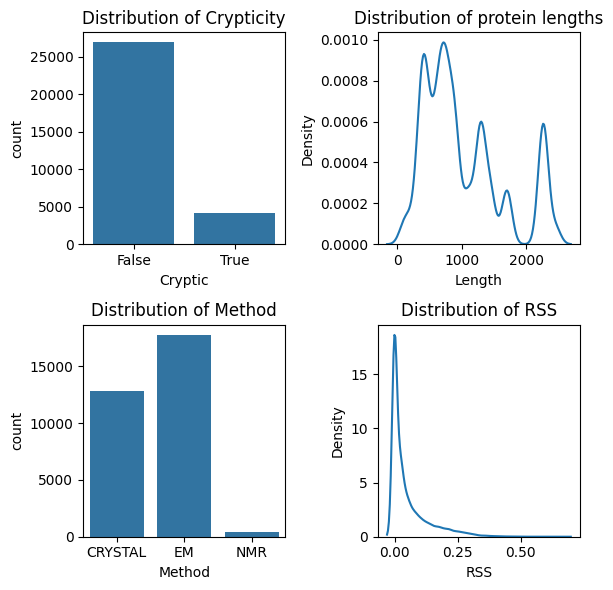

In [50]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
sns.countplot(newtrDF, x='Cryptic', ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Crypticity")
sns.kdeplot(newtrDF, x='Length', ax=ax[0, 1])
ax[0, 1].set_title("Distribution of protein lengths")
sns.countplot(newtrDF, x='Method', ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Method")
sns.kdeplot(newtrDF, x='RSS', ax=ax[1, 1])
ax[1, 1].set_title("Distribution of RSS")
plt.tight_layout()
fig.savefig('plots/data_summary_1.png', dpi=210, bbox_inches='tight')

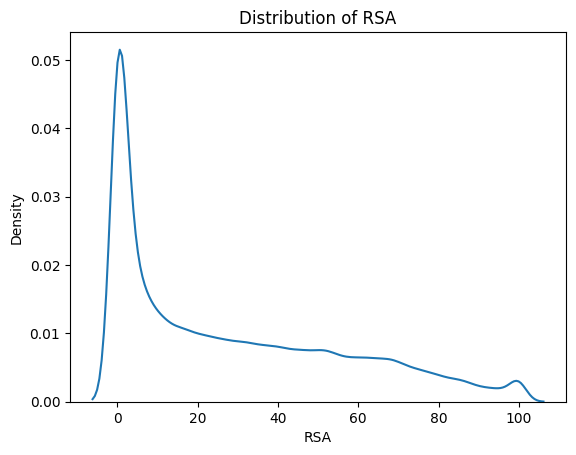

In [57]:
fig, ax = plt.subplots()
sns.kdeplot(dataset, x='RSA', ax=ax)
ax.set_title("Distribution of RSA")
fig.savefig("plots/data_summary_rsa.png", dpi=210, bbox_inches='tight')

/tmp/ipython-input-965851748.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"plots/data_summary_rsa_map_{random_gene}.png", bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


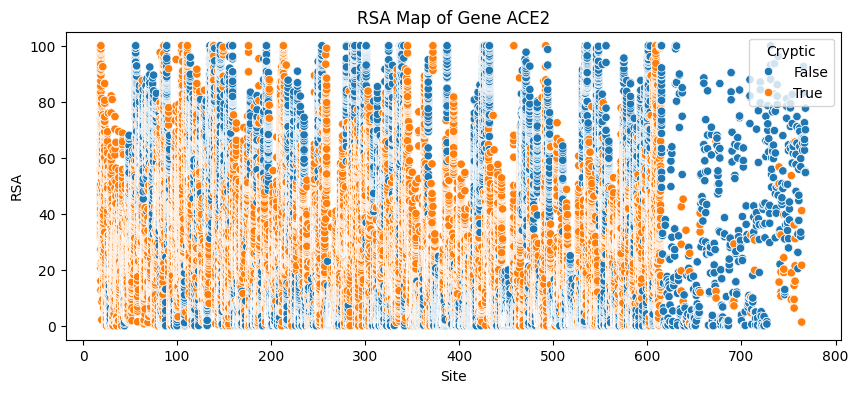

In [66]:
random_gene = dataset.sample(1).iloc[0].Gene_Name
gene_df = dataset.query("Gene_Name == @random_gene")
gene_df = gene_df.merge(newtrDF, on=['Gene_Name', 'Site'], how='left')
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
sns.scatterplot(gene_df, x='Site', y='RSA', hue='Cryptic', ax=ax)
ax.set_title(f"RSA Map of Gene {random_gene}")
fig.savefig(f"plots/data_summary_rsa_map_{random_gene}.png", bbox_inches='tight')

# Transformer Encoding of AA Sequence

In [6]:
qc = newtrDF.groupby(['Gene_Name', 'Site']).apply(lambda x: len(x.Amino_Acid.unique()))
qc = qc.reset_index()
qc

/tmp/ipython-input-331540011.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qc = newtrDF.groupby(['Gene_Name', 'Site']).apply(lambda x: len(x.Amino_Acid.unique()))


,Gene_Name,Site,0
0,A2ML1,19,1
1,A2ML1,20,1
2,A2ML1,21,1
3,A2ML1,22,1
4,A2ML1,23,1
...,...,...,...
31075,ADAM17,224,1
31076,ADAM17,225,1
31077,ADAM17,226,1
31078,ADAM17,227,1


In [7]:
qc[qc[0] != 1]

,Gene_Name,Site,0


In [8]:
trans_df = newtrDF[['Gene_Name', 'Site', 'AA_Code', 'Protein names', 'Cryptic']]
trans_df['Site'].min(), trans_df['Site'].max()

(np.int16(1), np.int16(2253))

In [9]:
len(trans_df['Gene_Name'].unique())

69

In [10]:
trans_df.drop_duplicates(['Gene_Name', 'Protein names'])

,Gene_Name,Site,AA_Code,Protein names,Cryptic
0,A2ML1,19,E,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
1376,AADAT,1,M,Kynurenine/alpha-aminoadipate aminotransferase...,True
1801,AAK1,33,G,AP2-associated protein kinase 1 (EC 2.7.11.1) ...,False
2086,AAMDC,2,T,Mth938 domain-containing protein (Adipogenesis...,False
2205,AASS,481,R,"Alpha-aminoadipic semialdehyde synthase, mitoc...",False
...,...,...,...,...,...
30108,ACVRL1,29,G,Serine/threonine-protein kinase receptor R3 (S...,False
30185,ACYP1,2,A,Acylphosphatase-1 (EC 3.6.1.7) (Acylphosphatas...,False
30283,ADA,5,P,Adenosine deaminase (EC 3.5.4.4) (Adenosine am...,False
30637,ADAM10,217,A,Disintegrin and metalloproteinase domain-conta...,False


In [11]:
trans_df['Protein names'].iloc[0]

'Alpha-2-macroglobulin-like protein 1 (C3 and PZP-like alpha-2-macroglobulin domain-containing protein 9)'

In [12]:
trans_df = trans_df.reset_index()
trans_df

,index,Gene_Name,Site,AA_Code,Protein names,Cryptic
0,0,A2ML1,19,E,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
1,1,A2ML1,20,L,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
2,2,A2ML1,21,P,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
3,3,A2ML1,22,N,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
4,4,A2ML1,23,Y,Alpha-2-macroglobulin-like protein 1 (C3 and P...,False
...,...,...,...,...,...,...
31075,31075,ADAM17,224,T,Disintegrin and metalloproteinase domain-conta...,False
31076,31076,ADAM17,225,C,Disintegrin and metalloproteinase domain-conta...,False
31077,31077,ADAM17,226,K,Disintegrin and metalloproteinase domain-conta...,False
31078,31078,ADAM17,227,L,Disintegrin and metalloproteinase domain-conta...,False


In [13]:
vocab = [
    'A', 'R', 'N', 'D', 'C', 'E', 'Q',
    'G', 'H', 'I', 'L', 'K', 'M', 'F',
    'P', 'S', 'T', 'W', 'Y', 'V', 'X',
    '<BEGIN>', '<END>', '<PAD>'
]
token_map = {t: i for i, t in enumerate(vocab)}
pad_len = trans_df['Site'].max()
def tokenize(df, gene_name):
  df = df.query('Gene_Name == @gene_name')
  longest = df['Site'].max()
  aa_seq = ['<BEGIN>']
  aa_seq.extend(['X' for _ in range(longest)])
  aa_seq.extend(['<PAD>' for _ in range(pad_len - longest)])
  aa_seq.append('<END>')
  def fill(row):
    aa_seq[row['Site']] = row['AA_Code']
  df.apply(fill, axis=1)

  return [token_map[i] for i in aa_seq]
genes = trans_df['Gene_Name'].unique()
aa_seqs = {
    gene: tokenize(trans_df, gene) for gene in genes
}

In [14]:
def split_by_gene(df, test_size, random_state):
  genes = df.Gene_Name.unique()
  np.random.seed(random_state)
  test_len = int(np.ceil(len(genes)*test_size))
  test_gene_idx = np.random.randint(low=0, high=len(genes), size=test_len)
  test_genes = genes[test_gene_idx]
  test_df = df.query('Gene_Name in @test_genes').copy()
  train_df = df.query('Gene_Name not in @test_genes').copy()
  return train_df, test_df

In [15]:
class RSA_set(Dataset):
  def __init__(self, df, y):
    self.df = df
    self.df.Site = self.df.Site.astype('int64')
    self.y = y.to_numpy()

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    gene_name = self.df.iloc[idx].Gene_Name
    aa_seq = aa_seqs[gene_name]
    return np.array(aa_seq, dtype=np.int64), self.df.iloc[idx].Site, int(self.y[idx])

train_df, test_df = split_by_gene(trans_df, test_size=0.2, random_state=114514)
print(sum(train_df['Cryptic']), sum(test_df['Cryptic']))
X_train = train_df[['Gene_Name', 'Site']].copy()
X_test = test_df[['Gene_Name', 'Site']].copy()
y_train = train_df['Cryptic'].copy()
y_test = test_df['Cryptic'].copy()
train_ds = RSA_set(X_train, y_train)
test_ds  = RSA_set(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

3648 520


In [15]:
class TransformerEncoder(nn.Module):
  def sinusoidal_positional_encoding(self, max_len: int, d_model: int):
    pe = np.zeros((max_len, d_model), dtype=np.float32)
    position = np.arange(max_len)[:, None]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

  def __init__(self, vocab_size, embedding_dim, token_dim, padding_idx, heads=2, ff=128, dropout=0.2):
    super().__init__()
    self.padding_idx = padding_idx

    self.emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

    pe = self.sinusoidal_positional_encoding(token_dim, embedding_dim).astype(np.float32)
    self.register_buffer("pe", torch.from_numpy(pe))

    self.mha = nn.MultiheadAttention(embedding_dim, heads, batch_first=True, dropout=dropout)
    self.ln1 = nn.LayerNorm(embedding_dim)
    self.ff = nn.Sequential(
        nn.Linear(embedding_dim, ff),
        nn.ReLU(),
        nn.Linear(ff, embedding_dim),
    )
    self.ln2 = nn.LayerNorm(embedding_dim)
    self.cls = nn.Sequential(
        nn.Linear(embedding_dim, embedding_dim),
        nn.ReLU(),
        nn.Linear(embedding_dim, 2)
    )

  def forward(self, x, positions):
    h = self.emb(x) + self.pe.unsqueeze(0)
    key_padding = (x == self.padding_idx)
    h2, attn = self.mha(h, h, h, key_padding_mask=key_padding, need_weights=True)
    h = self.ln1(h + h2)
    h2 = self.ff(h)
    h = self.ln2(h + h2)
    # extract encoding at target positions
    batch_idx = torch.arange(x.size(0), device=x.device, dtype=int)
    target_embedding = h[batch_idx, positions]
    encoded = self.cls(target_embedding)
    return encoded, target_embedding, attn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
embedding_dim = 64
token_dim = trans_df['Site'].max() + 2 # start and end, total 2255
heads = 10
model = TransformerEncoder(
    len(vocab), embedding_dim, token_dim, heads
).to(device)

cuda


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

39298

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
class_weights = torch.tensor([1, 6.5], dtype=torch.float32).to(device)
def run_epoch(loader, train=True):
  if train: model.train()
  else: model.eval()
  total, correct, losses = 0, 0, []
  for xb, positions, yb in loader:
    xb, positions, yb = xb.to(device), positions.to(device), yb.to(device)
    logits, _, _ = model(xb, positions)
    loss = F.cross_entropy(logits, yb, weight=class_weights)
    if train:
      opt.zero_grad()
      loss.backward()
      opt.step()
    pred = logits.argmax(dim=1)
    correct += (pred == yb).sum().item()
    total += yb.size(0)
    losses.append(loss.item())
  return np.mean(losses), correct / max(total, 1)

epochs = 50
patience = 7
patience_counter = 0
best_loss = float('inf')
pbar = tqdm(total=epochs)
for ep in range(epochs):
  tr_loss, tr_acc = run_epoch(train_loader, train=True)
  te_loss, te_acc = run_epoch(test_loader, train=False)

  if te_loss < best_loss:
    best_loss = te_loss
    patience_counter = 0
    torch.save(model.state_dict(), 'best_aa_encoder.pt')
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early stopping triggered at epoch {ep+1}. Restoring best model.")
      model.load_state_dict(torch.load('best_aa_encoder.pt'))
      break
  pbar.update(1)
  pbar.set_description(f"epoch {ep+1:02d}, train_loss={tr_loss:.2f}, train_acc={tr_acc:.2f}, test_acc={te_acc:.2f}")
pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 15. Restoring best model.


In [19]:
preds = []
labels = []
model.eval()
for xb, positions, yb in test_loader:
  xb, positions, yb = xb.to(device), positions.to(device), yb.to(device)
  with torch.no_grad():
    logits, _, _ = model(xb, positions)
  pred = logits.argmax(dim=1)
  preds.append(pred.to('cpu'))
  labels.append(yb.to('cpu'))

In [20]:
preds = np.concat(preds)
labels = np.concat(labels)

In [22]:
print(f"Transformer accuracy: {accuracy_score(labels, preds)}")
print(f"Transformer f1: {f1_score(labels, preds)}")

Transformer accuracy: 0.6671813347057814
Transformer f1: 0.19966996699669967


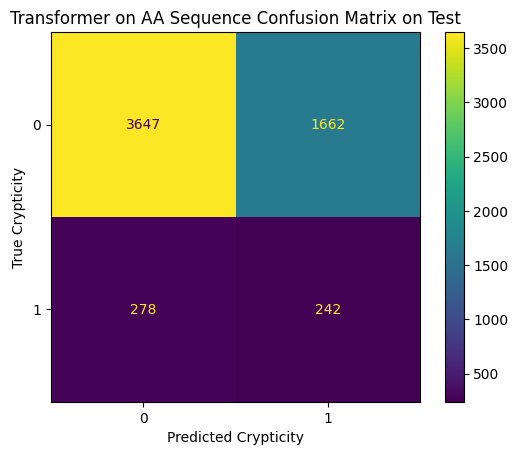

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax = ax)
ax.set_title('Transformer on AA Sequence Confusion Matrix on Test')
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel('True Crypticity')
fig.savefig('transformer_aa_cm.png', dpi=210)

In [24]:
torch.cuda.empty_cache()

### Trained Encoder of AA Sequence

In [16]:
vocab = [
    'A', 'R', 'N', 'D', 'C', 'E', 'Q',
    'G', 'H', 'I', 'L', 'K', 'M', 'F',
    'P', 'S', 'T', 'W', 'Y', 'V', 'X',
    '<BEGIN>', '<END>', '<PAD>'
]
token_map = {t: i for i, t in enumerate(vocab)}
pad_len = trans_df['Site'].max()
embedding_dim = 64
token_dim = trans_df['Site'].max() + 2 # start and end, total 2255
heads = 10
encoder = TransformerEncoder(
    len(vocab), embedding_dim, token_dim, heads
).to(device)
encoder.load_state_dict(
    torch.load('best_aa_encoder.pt', map_location=torch.device(device))
)

@torch.no_grad
def encode_aa(df, idx):
  encoder.eval()
  row = df.query('index==@idx').iloc[0]
  gene_name = row['Gene_Name']
  aa_seq = np.array(aa_seqs[gene_name], dtype=np.int64)
  x = torch.from_numpy(aa_seq)
  site = torch.tensor([row['Site']], dtype=torch.int64)
  x, site = x.to(device), site.to(device)
  _, embedding, _ = encoder(x.unsqueeze(0), site)
  return embedding.squeeze()
encode_aa(trans_df, 0)

tensor([-0.5105,  0.3832,  1.7487, -0.8666, -0.2401, -0.4037,  2.1798,  0.4436,
         0.0185,  1.4007, -0.6886, -0.7076, -0.8198,  0.3648,  0.1308, -0.5281,
         0.9557, -0.6417,  1.1478, -0.5723, -0.0849, -1.2552,  1.2964,  0.6974,
         0.2428, -0.0192,  0.3896,  0.9667, -0.7896,  1.3098,  0.0127,  0.4638,
        -1.6334, -0.3444, -2.2800,  2.0794,  0.3111,  0.8933,  0.3577,  1.2334,
        -0.2535,  0.4975, -1.0388,  0.0045, -1.3234,  0.9976, -2.2291,  0.7807,
        -0.2105, -0.1738,  0.0722,  1.5614,  1.2877, -0.6428, -1.5202, -0.3633,
        -2.6770,  0.2673, -1.0901,  0.5697, -0.5096,  0.2540,  0.0801, -0.8647])

In [ ]:
encoded_aas = [encode_aa(trans_df, i) for i in tqdm(range(len(trans_df)))]

  0%|          | 0/31080 [00:00<?, ?it/s]

In [ ]:
cpu_encoded_aas = [encoded.to('cpu') for encoded in encoded_aas]

In [ ]:
with open('aa_seq_encodings.pkl', 'wb') as file:
  pickle.dump(cpu_encoded_aas, file)

In [ ]:
with open('aa_seq_encodings.pkl', 'rb') as file:
  encoded_aas = pickle.load(file)
encoded_aas[0]

tensor([-0.5105,  0.3832,  1.7487, -0.8666, -0.2401, -0.4037,  2.1798,  0.4436,
         0.0185,  1.4007, -0.6886, -0.7076, -0.8198,  0.3648,  0.1308, -0.5281,
         0.9557, -0.6417,  1.1478, -0.5723, -0.0849, -1.2552,  1.2964,  0.6974,
         0.2428, -0.0192,  0.3896,  0.9667, -0.7896,  1.3098,  0.0127,  0.4638,
        -1.6334, -0.3444, -2.2800,  2.0794,  0.3111,  0.8933,  0.3577,  1.2334,
        -0.2535,  0.4975, -1.0388,  0.0045, -1.3234,  0.9976, -2.2291,  0.7807,
        -0.2105, -0.1738,  0.0722,  1.5614,  1.2877, -0.6428, -1.5202, -0.3633,
        -2.6770,  0.2673, -1.0901,  0.5697, -0.5096,  0.2540,  0.0801, -0.8647])

## Attention Map

In [17]:
vocab = [
    'A', 'R', 'N', 'D', 'C', 'E', 'Q',
    'G', 'H', 'I', 'L', 'K', 'M', 'F',
    'P', 'S', 'T', 'W', 'Y', 'V', 'X',
    '<BEGIN>', '<END>', '<PAD>'
]
@torch.no_grad
def get_attn(df, idx):
  encoder.eval()
  row = df.iloc[idx]
  gene_name = row['Gene_Name']
  aa_seq = np.array(aa_seqs[gene_name], dtype=np.int64)
  x = torch.from_numpy(aa_seq)
  site = torch.tensor([row['Site']], dtype=torch.int64)
  x, site = x.to(device), site.to(device)
  _, _, attn = encoder(x.unsqueeze(0), site)
  return np.array([vocab[i] for i in aa_seq]), attn.squeeze()
get_attn(trans_df, 0)

(array(['<BEGIN>', 'X', 'X', ..., '<PAD>', '<PAD>', '<END>'], dtype='<U7'),
 tensor([[3.4045e-04, 1.7203e-03, 1.7530e-03,  ..., 1.0765e-04, 9.5689e-05,
          4.9459e-04],
         [5.1511e-05, 5.0410e-04, 4.5870e-04,  ..., 7.6641e-05, 7.2002e-05,
          2.4897e-04],
         [3.4519e-05, 5.4299e-04, 4.9316e-04,  ..., 5.8611e-05, 5.5615e-05,
          2.6922e-04],
         ...,
         [1.3846e-05, 4.9249e-04, 3.8955e-04,  ..., 1.6390e-04, 1.4180e-04,
          1.2338e-04],
         [1.5604e-05, 5.2601e-04, 4.1909e-04,  ..., 2.0104e-04, 1.7372e-04,
          1.5168e-04],
         [1.2107e-04, 3.2679e-04, 2.9912e-04,  ..., 4.1137e-04, 3.9623e-04,
          1.8333e-04]]))

In [67]:
lengths = []
genes = []
for key, val in aa_seqs.items():
  length = len(val)
  for i in val[::-1]:
    if vocab[i] == '<END>' or vocab[i] == '<PAD>':
      length -= 1
    else:
      break
  lengths.append(length)
  genes.append(key)
lengths = np.array(lengths)
genes = np.array(genes)
idx = np.argsort(lengths)
genes = genes[idx]
lengths = lengths[idx]
print(genes[:5], lengths[:5])

['ABRACL' 'ACTG1' 'ACBD7' 'ACYP1' 'ACVRL1'] [ 82  85  89 100 106]


In [20]:
abracl = trans_df.query('Gene_Name=="ABRACL"')
abracl.iloc[0]

,17856
index,17856
Gene_Name,ABRACL
Site,1
AA_Code,M
Protein names,Costars family protein ABRACL (ABRA C-terminal...
Cryptic,False


In [25]:
def plot_attn_map(ax, df, row):
  tokens, attn = get_attn(df, row)
  attention_matrix = attn.detach().cpu().numpy()
  length = len(tokens)
  for i in tokens[::-1]:
    if i == '<END>' or i == '<PAD>':
      length -= 1
    else:
      break
  tokens = tokens[:length]
  def annotate_cryptic(row):
    if row.Cryptic:
      tokens[row.Site] += "(Cryp)"
  df.apply(annotate_cryptic, axis=1)
  attention_matrix = attention_matrix[:length, :length]

  sns.heatmap(
      attention_matrix,
      xticklabels=tokens,
      yticklabels=tokens,
      cmap="viridis",
      annot=False,
      ax=ax
  )

  ax.set_xlabel("Key (Attended To)")
  ax.set_ylabel("Query (Attending From)")

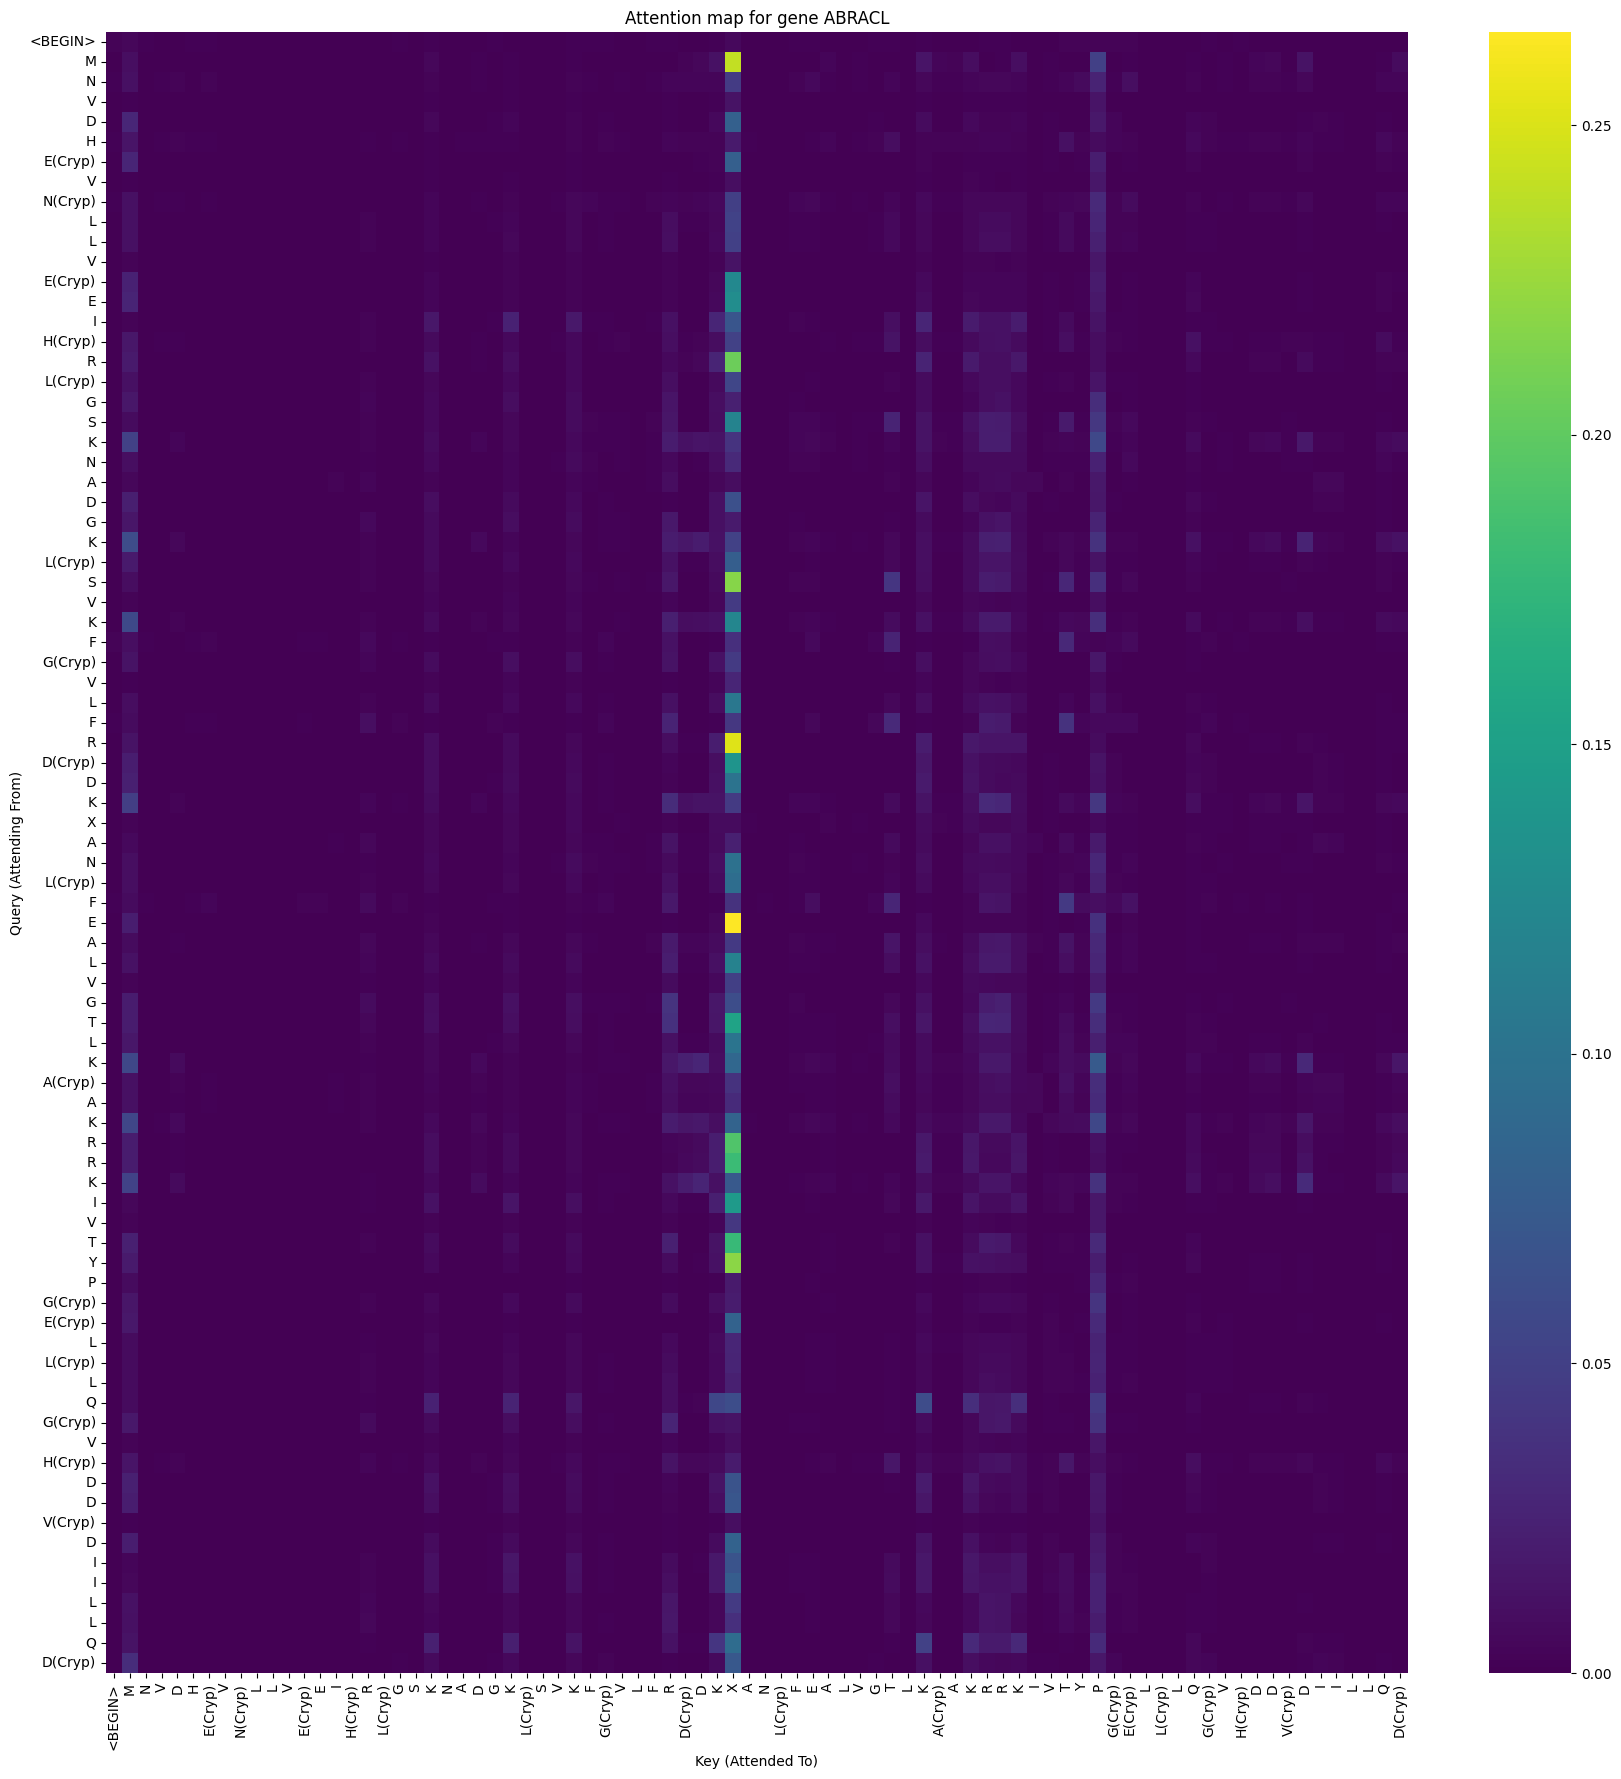

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 17)
row = 0
plt.tight_layout()
plot_attn_map(ax, abracl, row)
ax.set_title(f"Attention map for gene ABRACL")
fig.savefig("plots/attn_map_abracl.png", dpi=210, bbox_inches='tight')

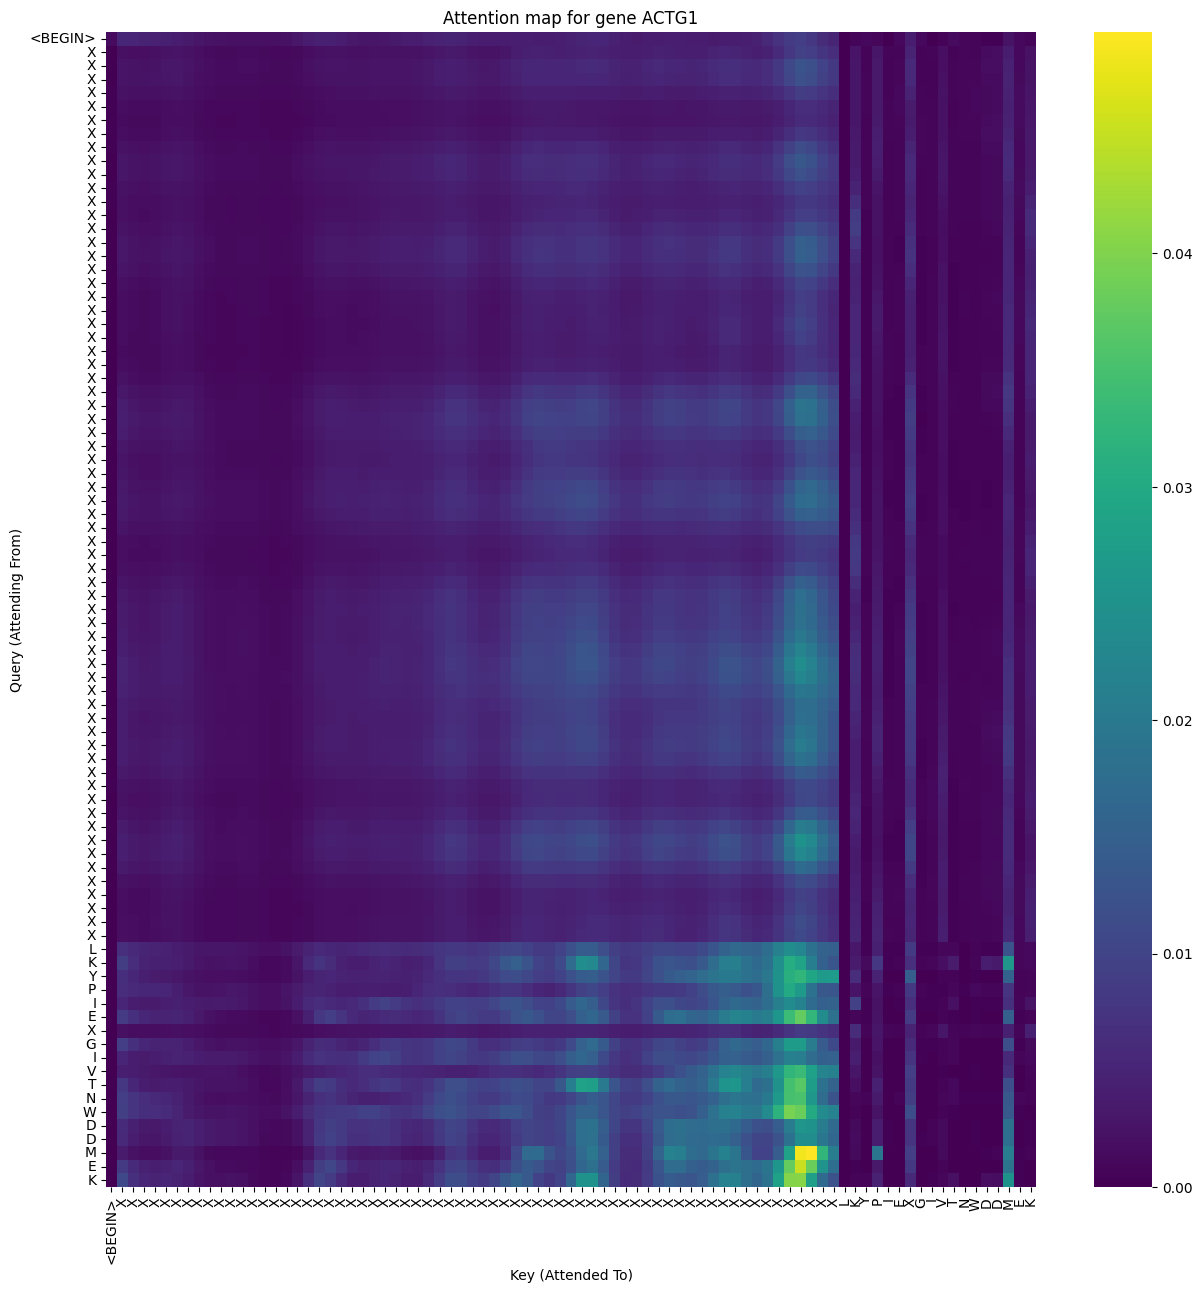

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ACTG1 = trans_df.query('Gene_Name=="ACTG1"')
row = 0
plot_attn_map(ax, ACTG1, row)
ax.set_title(f"Attention map for gene ACTG1")
fig.savefig("plots/attn_map_actg1.png", dpi=210, bbox_inches='tight')

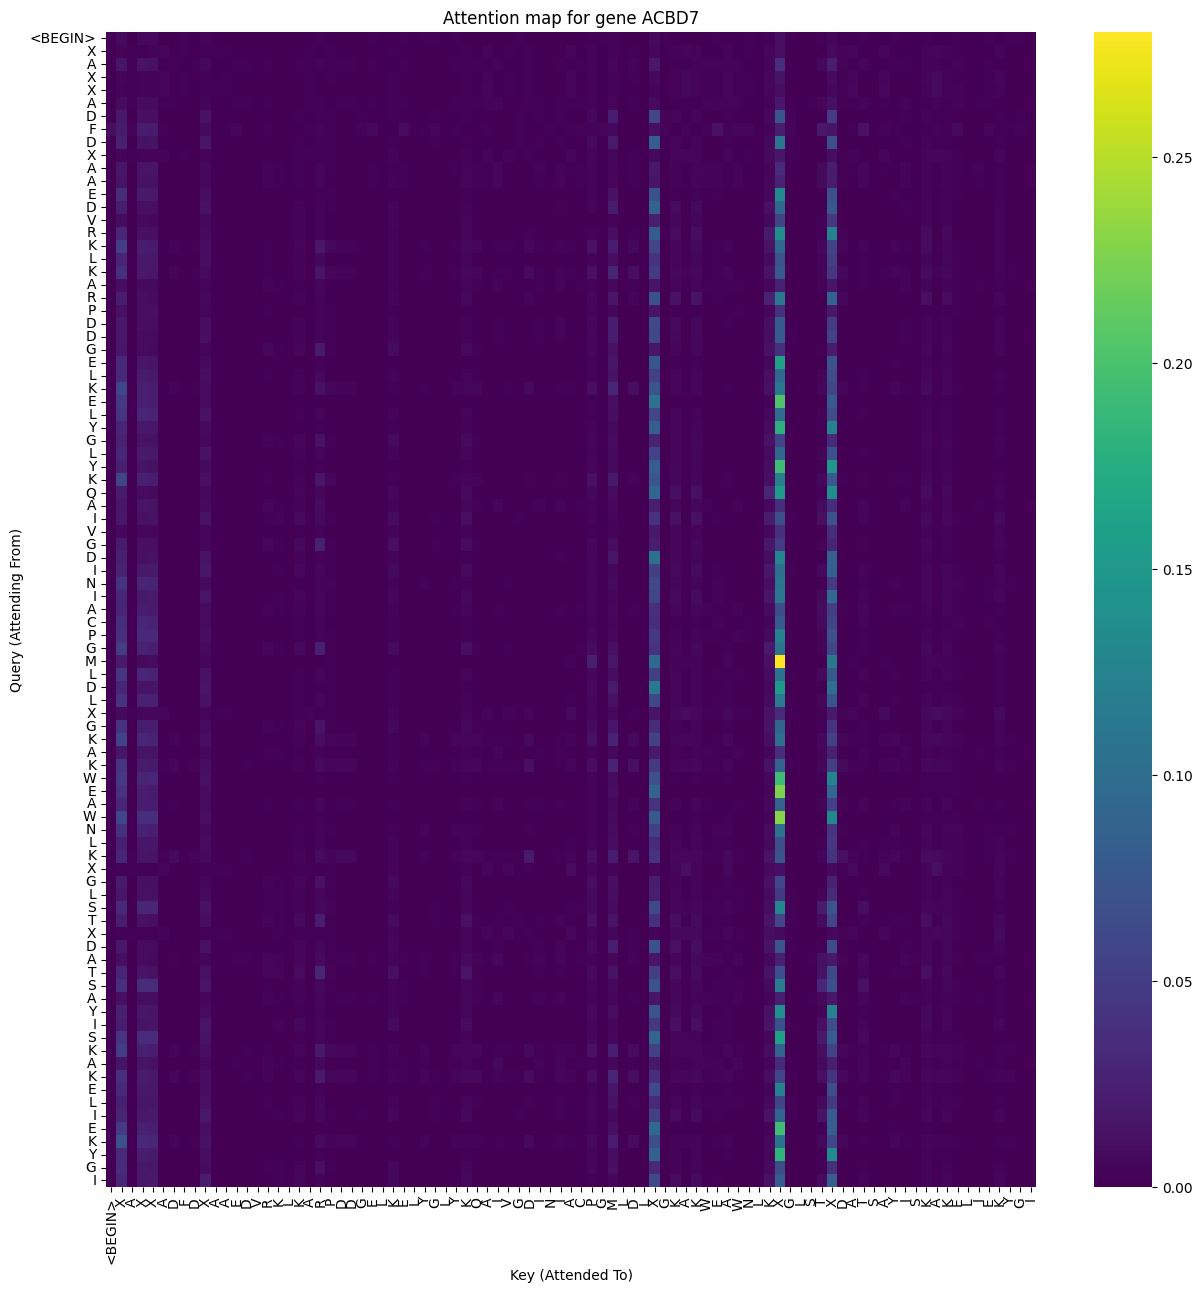

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ACBD7 = trans_df.query('Gene_Name=="ACBD7"')
row = 0
plot_attn_map(ax, ACBD7, row)
ax.set_title(f"Attention map for gene ACBD7")
fig.savefig("plots/attn_map_acbd7.png", dpi=210, bbox_inches='tight')

## Use pretrained encoder [MSR BiomedBERT](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext) to encode protein names

In [ ]:
from transformers import AutoTokenizer, AutoModel
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
pretrained_model = AutoModel.from_pretrained(MODEL_NAME)

KeyboardInterrupt: 

In [ ]:
@torch.no_grad
def encode_name(protein_name):
  encoded_input = tokenizer(protein_name, padding=True, return_tensors='pt')
  model_output = pretrained_model(**encoded_input)
  protein_embedding = model_output.last_hidden_state[:, 0, :]
  return protein_embedding.squeeze()
len(encode_name('Alpha-2-macroglobulin-like protein 1 (C3 and PZP-like alpha-2-macroglobulin domain-containing protein 9)'))

768

In [ ]:
names = trans_df['Protein names'].unique()
name_encodings = {name: encode_name(name) for name in names}

In [ ]:
with open('protein_name_encodings.pkl', 'wb') as file:
  pickle.dump(name_encodings, file)

In [ ]:
with open('protein_name_encodings.pkl', 'rb') as file:
  name_encodings = pickle.load(file)

In [ ]:
class ProteinNameSet(Dataset):
  def __init__(self, df, y):
    self.df = df
    self.y = y.to_numpy()

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    name = self.df.iloc[idx]['Protein names']
    protein_encoding = name_encodings[name]
    site_idx = self.df.iloc[idx]['index']
    site_encoding = encoded_aas[site_idx]
    return protein_encoding, site_encoding, int(self.y[idx])

train_df, test_df = split_by_gene(trans_df, test_size=0.2, random_state=114514)
print(sum(train_df['Cryptic']), sum(test_df['Cryptic']))
X_train = train_df[['index', 'Protein names']].copy()
X_test = test_df[['index', 'Protein names']].copy()
y_train = train_df['Cryptic'].copy()
y_test = test_df['Cryptic'].copy()

train_ds = ProteinNameSet(X_train, y_train)
test_ds  = ProteinNameSet(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

3648 520


In [ ]:
for x, y, z in train_loader:
  print(x.size())
  break

torch.Size([64, 768])


In [ ]:
class ProteinEncoder(nn.Module):
  def __init__(self, protein_dim, hidden_dim, site_dim):
    super().__init__()
    self.bn = nn.BatchNorm1d(protein_dim)
    self.ff1 = nn.Sequential(
      nn.Linear(protein_dim, hidden_dim*3),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(hidden_dim*3, hidden_dim*2),
    )
    self.ln1 = nn.LayerNorm(hidden_dim*2)
    self.ff2 = nn.Sequential(
      nn.Linear(hidden_dim*2, hidden_dim),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(hidden_dim, site_dim),
    )
    self.ln2 = nn.LayerNorm(site_dim)
    self.cls = nn.Linear(site_dim, 2)

  def forward(self, protein_encoding, site_encoding):
    # Modality Dropout (Training Only)
    if self.training:
      if torch.rand(1).item() < 0.3:
        protein_encoding = torch.zeros_like(protein_encoding)
      elif torch.rand(1).item() < 0.1:
        site_encoding = torch.zeros_like(site_encoding)
    mat = self.bn(protein_encoding)
    mat = self.ff1(mat)
    mat = self.ln1(mat)
    mat = self.ff2(mat)
    mat = site_encoding + 0.1*mat
    mat = self.ln2(mat)
    logit = self.cls(mat)
    return logit, mat

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
protein_dim = 768
hidden_dim = 128
site_dim = 64
model = ProteinEncoder(protein_dim, hidden_dim, site_dim).to(device)

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
class_weights = torch.tensor([1, 6.5], dtype=torch.float32).to(device)

def run_epoch(loader, train=True):
  if train: model.train()
  else: model.eval()
  total, correct, losses = 0, 0, []
  for protein_encoding, site_encoding, yb in loader:
    protein_encoding, site_encoding, yb = protein_encoding.to(device), site_encoding.to(device), yb.to(device)
    logits, _ = model(protein_encoding, site_encoding)
    loss = F.cross_entropy(logits, yb, weight = class_weights)
    if train:
      opt.zero_grad()
      loss.backward()
      opt.step()
    pred = logits.argmax(dim=1)
    correct += (pred == yb).sum().item()
    total += yb.size(0)
    losses.append(loss.item())
  return np.mean(losses), correct / max(total, 1)

epochs = 50
patience = 10
patience_counter = 0
best_loss = float('inf')
pbar = tqdm(total=epochs)
for ep in range(epochs):
  tr_loss, tr_acc = run_epoch(train_loader, train=True)
  te_loss, te_acc = run_epoch(test_loader, train=False)

  if te_loss < best_loss:
    best_loss = te_loss
    patience_counter = 0
    torch.save(model.state_dict(), 'best_protein_encoder.pt')
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early stopping triggered at epoch {ep+1}. Restoring best model.")
      model.load_state_dict(torch.load('best_protein_encoder.pt'))
      break
  pbar.update(1)
  pbar.set_description(f"epoch {ep+1:02d}, train_loss={tr_loss:.2f}, train_acc={tr_acc:.2f}, test_acc={te_acc:.2f}")
pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping triggered at epoch 22. Restoring best model.


In [ ]:
preds = []
labels = []
model.eval()
for protein_encoding, site_encoding, yb in test_loader:
  protein_encoding, site_encoding, yb = protein_encoding.to(device), site_encoding.to(device), yb.to(device)
  with torch.no_grad():
    logits, _ = model(protein_encoding, site_encoding)
  pred = logits.argmax(dim=1)
  preds.append(pred.to('cpu'))
  labels.append(yb.to('cpu'))

In [ ]:
preds = np.concat(preds)
labels = np.concat(labels)

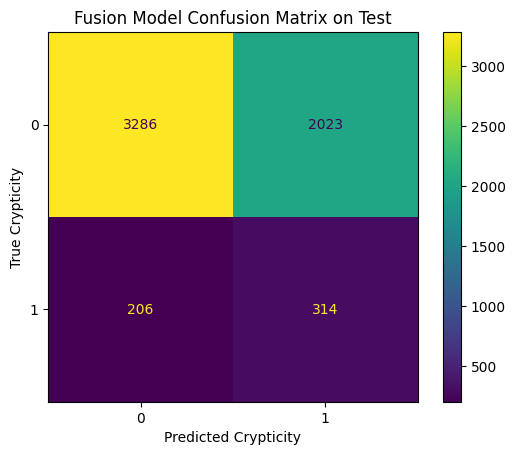

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax = ax)
ax.set_title('Fusion Model Confusion Matrix on Test')
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel('True Crypticity')
fig.savefig('fusion_cm.png', dpi=210)

In [ ]:
model.eval()
@torch.no_grad
def encode_row(df, idx):
  name = df.iloc[idx]['Protein names']
  protein_encoding = name_encodings[name]
  site_idx = df.iloc[idx]['index']
  site_encoding = encoded_aas[site_idx]
  protein_encoding, site_encoding = protein_encoding.to(device), site_encoding.to(device)
  _, encoding = model(protein_encoding.unsqueeze(0), site_encoding.unsqueeze(0))
  return encoding.squeeze()

In [ ]:
final_encodings = [encode_row(trans_df, i).to('cpu') for i in tqdm(range(len(trans_df)))]

  0%|          | 0/31080 [00:00<?, ?it/s]

In [ ]:
with open('final_encodings.pkl', 'wb') as file:
  pickle.dump(final_encodings, file)

In [ ]:
with open('final_encodings.pkl', 'rb') as file:
  final_encodings = pickle.load(file)
final_encodings[0]

tensor([-0.6870,  0.4499,  1.7584, -1.0319,  0.3608, -0.0532,  2.1651,  0.4790,
        -0.0386,  1.4734, -0.5352, -1.1868, -1.7819,  0.3989,  0.2137,  0.2205,
         0.5837, -0.4926,  0.3475, -1.2998, -0.4951, -0.7362,  2.6990,  0.8544,
         0.0611, -0.4766,  0.0560,  1.0540, -0.2880,  1.0912,  0.4640,  0.9287,
        -1.8914, -0.8072, -1.5327, -0.1467,  0.5523, -0.0539, -0.6321,  1.2907,
        -0.3260, -0.9476, -0.5774,  0.0552, -2.0619,  1.1689, -0.6138,  1.0434,
         0.3841, -0.3819,  0.0483,  0.9734,  1.7422, -0.8925, -1.3009, -0.5793,
        -2.2794,  0.0329, -0.4470,  0.5495,  0.5074, -0.2942, -0.0220,  0.6421])

# Single Models

## Preprocessing

**Identifiers (Do not include)**:
- 'Gene_Name'
- 'Uniprot_Accession_ID'
- 'Amino_Acid'
- 'AA_Abbr'
- 'From'
- 'Reviewed'
- 'Protein names'
- 'geneNamePrimary'

**Cryptic Info (Do not include -- Cheating!)**:
- 'Low'
- 'High'
- 'Diff'
- 'AvgRSA'
- 'StdRSA'
- 'CVRSA_%'
- 'Cryptic'

**Could Include, Might be Useful**:
- 'Site'
- 'Chain'
- 'Length'

**Should Include**:
- ***Numeric (drop NaNs)***: 'RSS', 'Hydrophobicity', 'Residue_Weight_-H2O', 'Residue_pKa_NH2', 'Residue_pKa_COOH', 'Residue_pI', 'Residue_Volume_A3', 'RSA_Sample_1', (OPTIONALLY or sequentially 'RSA_Sample_2', 'RSA_Sample_3')
- ***Categorical (bool)***: Modification cols ('phospho', 'tele-methyl', 'n6-succinyl', 'n6-methyl', 's-glutathionyl ', 'n6-(pyridoxal phosphate)', '(r)-sulfoxide', 'n-acetyl', 'n6-acetyl')
- ***Categorical (need one-hot encoding)***: 'Method', 'Side_Chain', 'AA_Code', 'Residue_Charge'

**Probably Helpful**:
- Include several (3-5) observations of RSA values, randomly sampled from the raw dataset (merge on Gene_Name + Site)

In [9]:
res_chem_feats = ['Hydrophobicity', 'Residue_Weight_-H2O', 'Residue_pKa_NH2', 'Residue_pKa_COOH', 'Residue_pI', 'Residue_Volume_A3']
res_evol_feats = ['RSS']
rsa_cols = ['RSA_Sample_1', 'RSA_Sample_2', 'RSA_Sample_3']
res_mod_feats = ['phospho', 'tele-methyl', 'n6-succinyl', 'n6-methyl', 's-glutathionyl ', 'n6-(pyridoxal phosphate)', '(r)-sulfoxide', 'n-acetyl', 'n6-acetyl']
protein_feats = ['Site', 'Length']
numeric_feats = np.concat([res_chem_feats, res_evol_feats, rsa_cols, res_mod_feats, protein_feats])
categorical_feats = ['Chain', 'Method', 'Side_Chain', 'AA_Code', 'Residue_Charge']
label = ['Cryptic']
dfmodel = newtrDF[np.concat([numeric_feats, categorical_feats, label])].copy()
dfmodel

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,n-acetyl,n6-acetyl,Site,Length,Chain,Method,Side_Chain,AA_Code,Residue_Charge,Cryptic
0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,75.2,...,False,False,19,1454.0,A,EM,polar_acidic,E,+,False
1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,86.5,...,False,False,20,1454.0,A,EM,hydrophobic,L,N,False
2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,31.3,...,False,False,21,1454.0,A,EM,unique,P,N,False
3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,6.4,...,False,False,22,1454.0,A,EM,polar_neutral,N,-,False
4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,3.8,...,False,False,23,1454.0,B,EM,hydrophobic,Y,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,0.1,...,False,False,224,824.0,E,CRYSTAL,polar_neutral,T,N,False
31076,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,0.0,...,False,False,225,824.0,A,CRYSTAL,polar_neutral,C,N,False
31077,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,13.2,...,False,False,226,824.0,B,CRYSTAL,polar_basic,K,N,False
31078,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,0.0,...,False,False,227,824.0,A,CRYSTAL,hydrophobic,L,N,False


In [10]:
dfmodel[dfmodel.isna().apply(lambda row: np.any(row), axis=1)]

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,n-acetyl,n6-acetyl,Site,Length,Chain,Method,Side_Chain,AA_Code,Residue_Charge,Cryptic
1398,13,101.11,9.24,2.58,5.60,116.1,NaN,91.8,56.7,56.7,...,False,False,23,425.0,D,CRYSTAL,polar_neutral,T,N,True
1399,-55,115.09,9.67,2.19,2.77,111.1,NaN,59.0,59.0,39.5,...,False,False,24,425.0,A,CRYSTAL,polar_acidic,D,-,False
1400,99,113.16,8.97,1.78,6.02,166.7,NaN,44.8,44.8,21.1,...,False,False,25,425.0,A,CRYSTAL,hydrophobic,I,+,True
1401,97,113.16,9.21,2.28,5.98,166.7,NaN,43.0,43.0,33.7,...,False,False,26,425.0,A,CRYSTAL,hydrophobic,L,N,False
1402,-5,87.08,9.60,2.36,5.68,89.0,NaN,71.2,71.2,58.8,...,False,False,27,425.0,C,CRYSTAL,polar_neutral,S,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30279,-10,128.13,9.15,2.21,5.65,138.4,NaN,72.5,88.0,68.5,...,False,False,96,99.0,A,NMR,polar_neutral,Q,N,False
30280,99,113.16,8.97,1.78,6.02,166.7,NaN,23.4,37.1,20.2,...,False,False,97,99.0,A,NMR,hydrophobic,I,+,True
30281,76,99.13,9.11,2.20,5.96,140.0,NaN,42.9,40.6,43.7,...,False,False,98,99.0,A,NMR,hydrophobic,V,N,False
30282,41,71.08,9.09,2.18,6.00,88.6,NaN,100.0,100.0,93.9,...,False,False,99,99.0,A,NMR,hydrophobic,A,+,False


In [11]:
dfmodel.isna().apply(lambda col: np.any(col))

,0
Hydrophobicity,False
Residue_Weight_-H2O,False
Residue_pKa_NH2,False
Residue_pKa_COOH,False
Residue_pI,False
Residue_Volume_A3,False
RSS,True
RSA_Sample_1,False
RSA_Sample_2,False
RSA_Sample_3,False


In [12]:
# RUN THIS CELL IF YOU WANT TO DROP ROWS WITH MISSING VALUES
dfmodel = dfmodel.dropna(axis=0, how='any').reset_index(drop=True)
dfmodel

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,n-acetyl,n6-acetyl,Site,Length,Chain,Method,Side_Chain,AA_Code,Residue_Charge,Cryptic
0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,75.2,...,False,False,19,1454.0,A,EM,polar_acidic,E,+,False
1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,86.5,...,False,False,20,1454.0,A,EM,hydrophobic,L,N,False
2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,31.3,...,False,False,21,1454.0,A,EM,unique,P,N,False
3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,6.4,...,False,False,22,1454.0,A,EM,polar_neutral,N,-,False
4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,3.8,...,False,False,23,1454.0,B,EM,hydrophobic,Y,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,0.1,...,False,False,224,824.0,E,CRYSTAL,polar_neutral,T,N,False
27840,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,0.0,...,False,False,225,824.0,A,CRYSTAL,polar_neutral,C,N,False
27841,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,13.2,...,False,False,226,824.0,B,CRYSTAL,polar_basic,K,N,False
27842,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,0.0,...,False,False,227,824.0,A,CRYSTAL,hydrophobic,L,N,False


In [13]:
len(dfmodel[dfmodel['Cryptic']]), len(dfmodel[~dfmodel['Cryptic']])

(3762, 24082)

In [14]:
24082/3762

6.4013822434875065

In [15]:
class_weight={0: 1, 1: 6.5} # it's 6.5 times more important to correctly classify a cryptic site

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(dfmodel[categorical_feats])
encoded_categorical_feats = encoder.get_feature_names_out(input_features=categorical_feats)
encoded_df = pd.DataFrame(encoded, columns=encoded_categorical_feats)
dfmodel = pd.concat([
    dfmodel.drop(columns=categorical_feats),
    encoded_df
], axis=1)
dfmodel

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,AA_Code_Q,AA_Code_R,AA_Code_S,AA_Code_T,AA_Code_V,AA_Code_W,AA_Code_Y,Residue_Charge_+,Residue_Charge_-,Residue_Charge_N
0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,75.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,86.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,31.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,3.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,0.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
27840,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27841,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,13.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27842,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
X = dfmodel.drop(columns=["Cryptic"])
y = dfmodel["Cryptic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514, stratify=y)

## Normalize numerical features

In [15]:
def normalize_numeric_cols(df, numeric_cols, scaler=None):
  if scaler is None:
    scaler = StandardScaler()
    train=True
  else:
    train=False
  df = df.copy()
  num_df = df[numeric_cols]
  if train:
    df[numeric_cols] = scaler.fit_transform(num_df)
    return df, scaler
  else:
    df[numeric_cols] = scaler.transform(num_df)
    return df, scaler

In [16]:
X_train, scaler = normalize_numeric_cols(X_train, numeric_feats)
X_test, _ = normalize_numeric_cols(X_test, numeric_feats, scaler)

## Random Forest

In [95]:
rf_model = RandomForestClassifier(
  n_estimators=300,
  min_samples_split=20,
  min_samples_leaf=10,
  class_weight=class_weight,
  random_state=114514,
  n_jobs=-1,
  verbose=True
)

In [96]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


Accuracy: 0.8125336685221763
F1 Score: 0.4846989141164857


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.4s finished


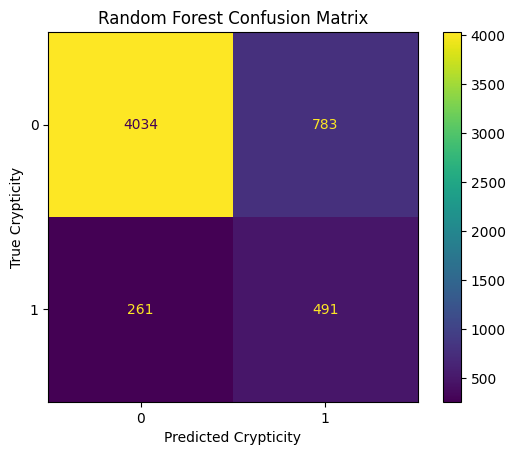

In [98]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("Random Forest Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/rf_cm.png", dpi=210)

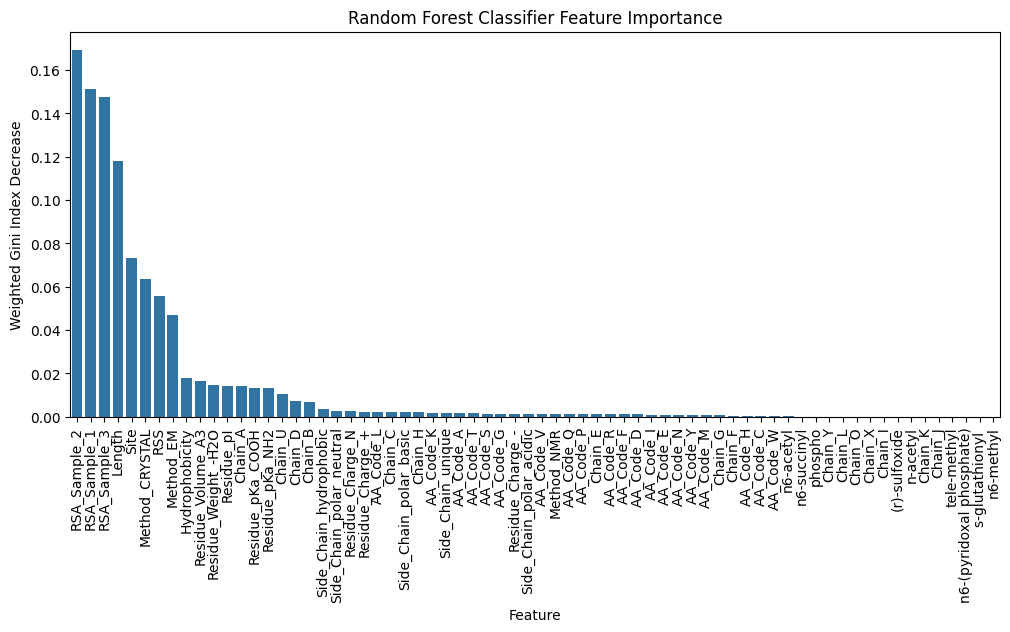

In [80]:
importances_rf = rf_model.feature_importances_
all_feature_names = rf_model.feature_names_in_
indices_rf = np.argsort(importances_rf)[::-1]
importances_rf = importances_rf[indices_rf]
all_feature_names = all_feature_names[indices_rf]

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.barplot(x=all_feature_names, y=importances_rf, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Weighted Gini Index Decrease")
ax.set_title("Random Forest Classifier Feature Importance")
fig.savefig('plots/rf_builtin_feat_importance.png', dpi=210)

## Logistic Regression

In [23]:
lr_model = LogisticRegression(
    max_iter=10000,
    class_weight=class_weight,
    solver="lbfgs",
    verbose=True,
    n_jobs=-1
)
lr_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


LogisticRegression(class_weight={0: 1, 1: 6.5}, max_iter=10000, n_jobs=-1,
                   verbose=True)

In [24]:
y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.646794756688813
F1 Score: 0.35061076262793


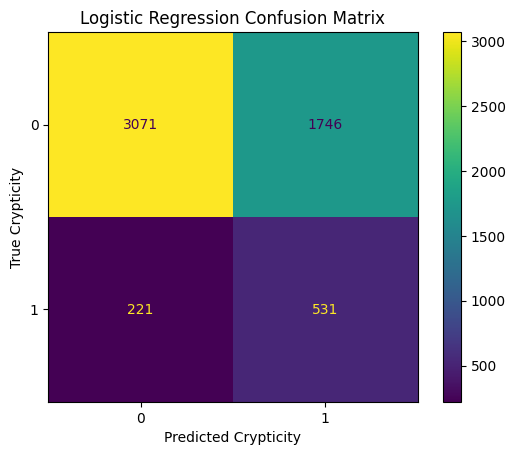

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("Logistic Regression Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/lr_cm.png", dpi=210)

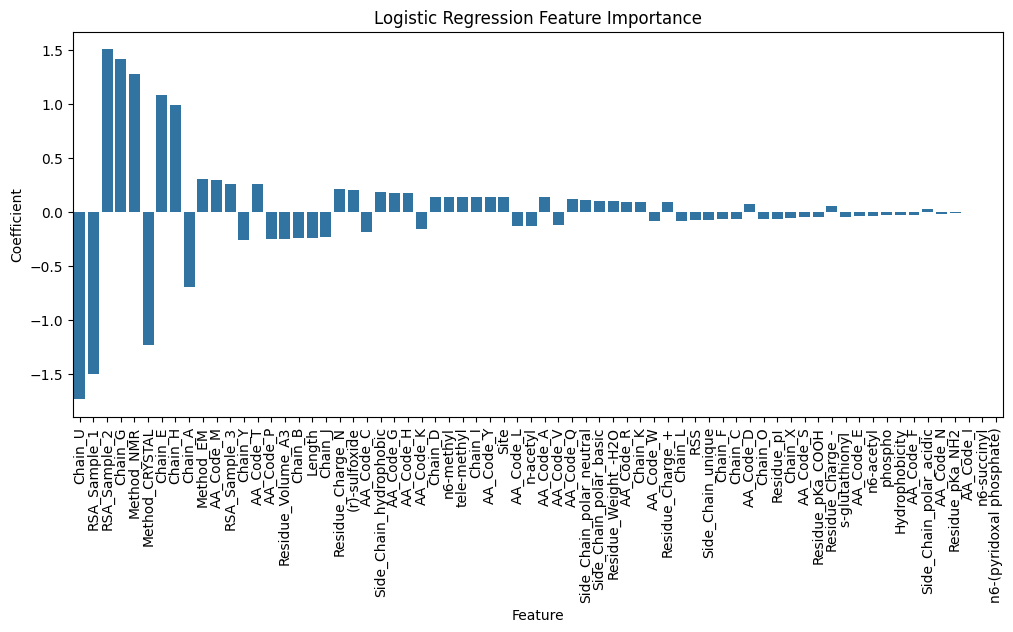

In [26]:
importances = lr_model.coef_[0]
all_feature_names = lr_model.feature_names_in_
indices = np.argsort(np.abs(importances))[::-1]
importances = importances[indices]
all_feature_names = all_feature_names[indices]

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.barplot(x=all_feature_names, y=importances, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Coefficient")
ax.set_title("Logistic Regression Feature Importance")
fig.savefig('plots/lr_builtin_feat_importance.png', dpi=210)

## Decision Tree

In [102]:
dt_model = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight=class_weight,
    random_state=114514
)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred))

Decision Tree Accuracy: 0.7997845214580714
Decision Tree F1 Score: 0.4970681100586378


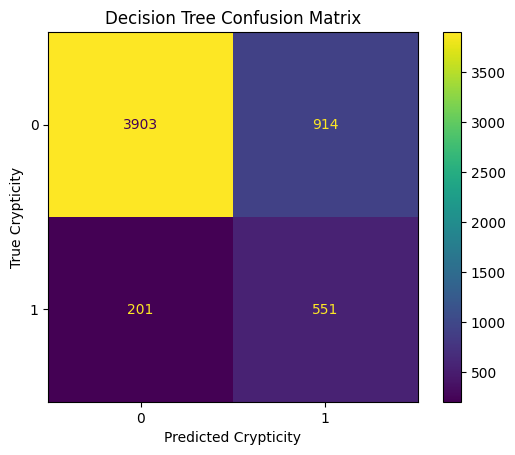

In [103]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("Decision Tree Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/dt_cm.png", dpi=210)

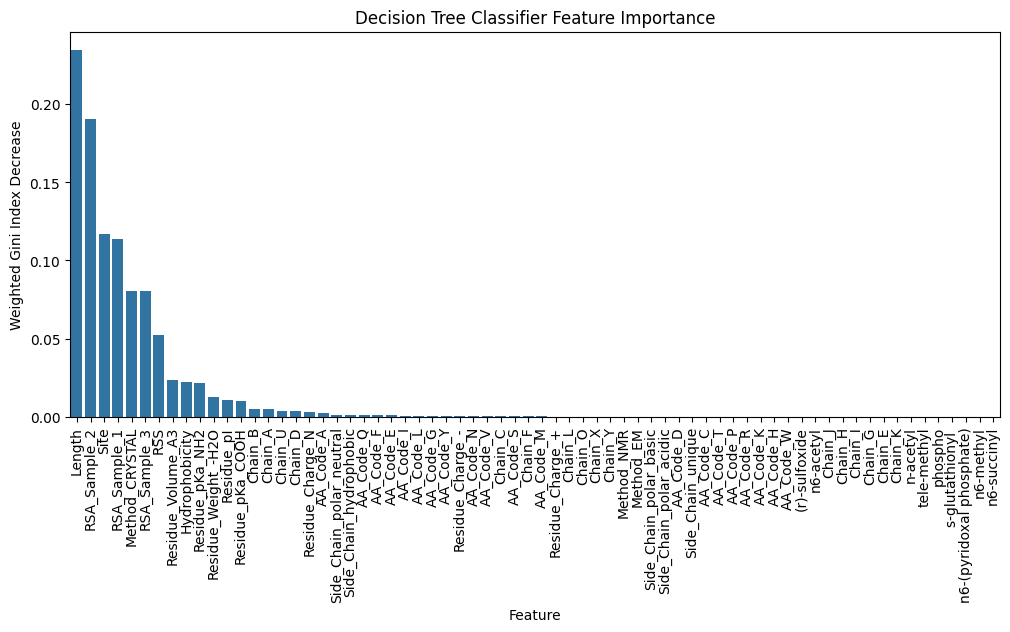

In [94]:
importances = dt_model.feature_importances_
all_feature_names = dt_model.feature_names_in_
indices = np.argsort(importances)[::-1]
importances = importances[indices]
all_feature_names = all_feature_names[indices]

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.barplot(x=all_feature_names, y=importances, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Weighted Gini Index Decrease")
ax.set_title("Decision Tree Classifier Feature Importance")
fig.savefig('plots/dt_builtin_feat_importance.png', dpi=210)

## KNN Classifier

In [110]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=114514)
knn_model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.linspace(5, 100, 5, dtype=int),
    'weights': ['uniform', 'distance']
}
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([  5,  28,  52,  76, 100]),
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [112]:
best_k = grid_search.best_params_['n_neighbors']
print(f"The best number of neighbors (k) found is: {best_k}")
best_w = grid_search.best_params_['weights']
print(f"The best weight found is: {best_w}")
best_score = grid_search.best_score_
print(f"The best cross-validation F1 score is: {best_score:.4f}")

The best number of neighbors (k) found is: 5
The best weight found is: distance
The best cross-validation F1 score is: 0.2817


In [113]:
best_knn_model = grid_search.best_estimator_
best_knn_model.fit(X_train, y_train)
y_pred = best_knn_model.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred))
print("KNN F1 Score:", f1_score(y_test, y_pred))

KNN Accuracy: 0.8565272041659184
KNN F1 Score: 0.29229406554472986


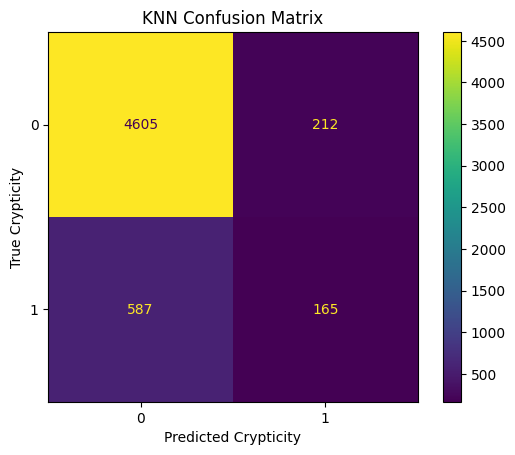

In [115]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("KNN Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/knn_cm.png", dpi=210)

## Support Vector Machine

In [20]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=114514)
svc_model = SVC(
    class_weight=class_weight,
    random_state=114514
)
gammas = ['scale']
gammas.extend(np.logspace(-2, 2, 100))
param_distributions = {
    'C': np.logspace(-2, 2, 100),
    'gamma': gammas,
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
random_search = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=param_distributions,
    scoring='f1',
    n_iter=20,
    cv=cv,
    n_jobs=-1,
    random_state=114514,
    verbose=2,
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=114514, shuffle=True),
                   estimator=SVC(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35...
                                                  np.float64(0.06428073117284322),
                                                  np.float64(0.07054802310718646),
                                                  np.float64(0.0774263682681127),
                                                  np.float64(0.08497534359086446),
                                                  np.float64(0.093260334688322),
                                                  np.float64(0.10235310218990264),
                                                  np.float64(0.11233240329780277),
                                                  np.float64(0.12328467394420665),
                                                  np.float64(0.13530477745798075), ...],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=114514, scoring='f1', verbose=2)

In [22]:
best_score = random_search.best_score_
print(f"The best cross-validation F1 score is: {best_score:.4f}")

The best cross-validation F1 score is: 0.4254


In [29]:
best_svc_model = random_search.best_estimator_
print(best_svc_model.get_params())
best_svc_model.fit(X_train, y_train)
y_pred = best_svc_model.predict(X_test)
print("SVC Accuracy:", accuracy_score(y_test, y_pred))
print("SVC F1 Score:", f1_score(y_test, y_pred))

{'handle': <pylibraft.common.handle.Handle object at 0x781e774f55f0>, 'verbose': 4, 'output_type': 'input', 'C': np.float64(4.641588833612782), 'kernel': 'poly', 'degree': 3, 'gamma': np.float64(0.05857020818056667), 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': 114514, 'class_weight': {0: 1, 1: 6.5}, 'multiclass_strategy': 'ovo'}
SVC Accuracy: 0.7399892260729036
SVC F1 Score: 0.42630744849445323


In [30]:
with open('best_svc_params.pickle', 'wb') as file:
  pickle.dump(best_svc_model.get_params(), file)

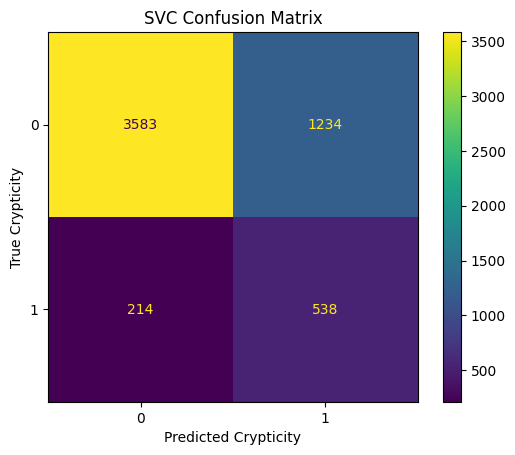

In [31]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("SVC Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/svc_cm.png", dpi=210)

# Hybrid RF + Transformer

### Incorporate transformer encodings

In [19]:
df_hybrid = newtrDF[np.concat([numeric_feats, categorical_feats, label])].copy().reset_index()
df_hybrid = df_hybrid.dropna(axis=0, how='any').reset_index(drop=True)
df_hybrid

,index,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,...,n-acetyl,n6-acetyl,Site,Length,Chain,Method,Side_Chain,AA_Code,Residue_Charge,Cryptic
0,0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,...,False,False,19,1454.0,A,EM,polar_acidic,E,+,False
1,1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,...,False,False,20,1454.0,A,EM,hydrophobic,L,N,False
2,2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,...,False,False,21,1454.0,A,EM,unique,P,N,False
3,3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,...,False,False,22,1454.0,A,EM,polar_neutral,N,-,False
4,4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,...,False,False,23,1454.0,B,EM,hydrophobic,Y,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,31075,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,...,False,False,224,824.0,E,CRYSTAL,polar_neutral,T,N,False
27840,31076,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,...,False,False,225,824.0,A,CRYSTAL,polar_neutral,C,N,False
27841,31077,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,...,False,False,226,824.0,B,CRYSTAL,polar_basic,K,N,False
27842,31078,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,...,False,False,227,824.0,A,CRYSTAL,hydrophobic,L,N,False


In [21]:
# append transformer encodings
with open('final_encodings.pkl', 'rb') as file:
  final_encodings = pickle.load(file)
final_encodings[0]

tensor([-0.6870,  0.4499,  1.7584, -1.0319,  0.3608, -0.0532,  2.1651,  0.4790,
        -0.0386,  1.4734, -0.5352, -1.1868, -1.7819,  0.3989,  0.2137,  0.2205,
         0.5837, -0.4926,  0.3475, -1.2998, -0.4951, -0.7362,  2.6990,  0.8544,
         0.0611, -0.4766,  0.0560,  1.0540, -0.2880,  1.0912,  0.4640,  0.9287,
        -1.8914, -0.8072, -1.5327, -0.1467,  0.5523, -0.0539, -0.6321,  1.2907,
        -0.3260, -0.9476, -0.5774,  0.0552, -2.0619,  1.1689, -0.6138,  1.0434,
         0.3841, -0.3819,  0.0483,  0.9734,  1.7422, -0.8925, -1.3009, -0.5793,
        -2.2794,  0.0329, -0.4470,  0.5495,  0.5074, -0.2942, -0.0220,  0.6421])

In [23]:
encoding_df = pd.DataFrame(final_encodings)
encoding_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,tensor(-0.6870),tensor(0.4499),tensor(1.7584),tensor(-1.0319),tensor(0.3608),tensor(-0.0532),tensor(2.1651),tensor(0.4790),tensor(-0.0386),tensor(1.4734),...,tensor(-1.3009),tensor(-0.5793),tensor(-2.2794),tensor(0.0329),tensor(-0.4470),tensor(0.5495),tensor(0.5074),tensor(-0.2942),tensor(-0.0220),tensor(0.6421)
1,tensor(0.0475),tensor(0.4869),tensor(1.3887),tensor(-2.1334),tensor(-0.9280),tensor(0.0209),tensor(2.2899),tensor(-0.9565),tensor(-0.3997),tensor(1.0202),...,tensor(-1.5113),tensor(0.5345),tensor(-1.0123),tensor(1.3897),tensor(-0.1503),tensor(1.0765),tensor(0.0381),tensor(-0.3402),tensor(-0.9092),tensor(2.3241)
2,tensor(0.1978),tensor(0.0809),tensor(1.4808),tensor(-1.4637),tensor(-0.5457),tensor(1.2988),tensor(1.3199),tensor(-0.6724),tensor(0.6739),tensor(1.2089),...,tensor(-1.5172),tensor(0.0723),tensor(0.3740),tensor(2.0081),tensor(-0.6550),tensor(0.5027),tensor(-0.1052),tensor(-1.3208),tensor(1.3212),tensor(1.7742)
3,tensor(-0.9117),tensor(0.0150),tensor(-0.2422),tensor(-1.2996),tensor(0.1346),tensor(0.1686),tensor(1.4085),tensor(-0.0807),tensor(1.6617),tensor(-0.1420),...,tensor(-2.2717),tensor(0.8208),tensor(-0.6904),tensor(-0.4647),tensor(0.4618),tensor(1.1669),tensor(0.9551),tensor(-0.3446),tensor(-0.6987),tensor(1.1979)
4,tensor(-1.9148),tensor(-0.0268),tensor(0.0986),tensor(-1.3094),tensor(0.2861),tensor(1.0203),tensor(1.6992),tensor(-0.5541),tensor(0.2089),tensor(0.7749),...,tensor(-1.1933),tensor(0.8789),tensor(-1.1375),tensor(0.8179),tensor(0.1649),tensor(0.8658),tensor(0.6231),tensor(-0.6099),tensor(0.9819),tensor(2.6448)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,tensor(-1.0052),tensor(0.4980),tensor(-0.2812),tensor(-0.8416),tensor(0.0971),tensor(0.5227),tensor(1.8896),tensor(1.7214),tensor(0.3572),tensor(0.4845),...,tensor(-1.1871),tensor(0.6292),tensor(-1.0855),tensor(-0.2155),tensor(0.5848),tensor(0.7963),tensor(0.6800),tensor(-0.6426),tensor(-0.3744),tensor(1.8646)
31076,tensor(-0.4310),tensor(0.3396),tensor(-0.4497),tensor(-0.4830),tensor(0.4645),tensor(0.3050),tensor(1.7663),tensor(1.5380),tensor(0.8953),tensor(0.5982),...,tensor(-1.2679),tensor(1.2339),tensor(-0.4622),tensor(0.0172),tensor(-0.2798),tensor(-0.2956),tensor(0.8843),tensor(-2.3570),tensor(0.2615),tensor(1.8949)
31077,tensor(0.1953),tensor(0.4494),tensor(0.5240),tensor(-0.6343),tensor(0.9246),tensor(-0.5910),tensor(0.4178),tensor(0.5924),tensor(0.7012),tensor(-1.0115),...,tensor(-1.5852),tensor(0.7711),tensor(-0.3028),tensor(0.5132),tensor(-0.2196),tensor(1.4569),tensor(-0.0820),tensor(-0.3372),tensor(0.0997),tensor(1.3512)
31078,tensor(-0.0240),tensor(1.1687),tensor(1.3098),tensor(-0.6995),tensor(0.3219),tensor(-0.4625),tensor(1.6982),tensor(0.5238),tensor(0.3238),tensor(-0.5539),...,tensor(-1.4603),tensor(0.6509),tensor(-0.8900),tensor(0.8746),tensor(-0.5311),tensor(0.8902),tensor(0.8291),tensor(-0.6634),tensor(0.2304),tensor(2.0223)


In [26]:
encoding_df = encoding_df.astype(float)
encoding_df = encoding_df.rename(columns={i: f'transformer_encoding_{i}' for i in range(64)})

In [27]:
df_hybrid = df_hybrid.merge(encoding_df.reset_index(), on='index', how='left')

In [29]:
df_hybrid = df_hybrid.drop(columns='index')
df_hybrid.to_csv("hybrid_model_df.csv", index=False)

In [5]:
df_hybrid = pd.read_csv("hybrid_model_df.csv")
df_hybrid

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,transformer_encoding_54,transformer_encoding_55,transformer_encoding_56,transformer_encoding_57,transformer_encoding_58,transformer_encoding_59,transformer_encoding_60,transformer_encoding_61,transformer_encoding_62,transformer_encoding_63
0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,75.2,...,-1.300867,-0.579260,-2.279440,0.032939,-0.447004,0.549537,0.507386,-0.294216,-0.022012,0.642099
1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,86.5,...,-1.511253,0.534496,-1.012266,1.389674,-0.150271,1.076506,0.038081,-0.340156,-0.909151,2.324072
2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,31.3,...,-1.517222,0.072310,0.374022,2.008109,-0.654986,0.502726,-0.105154,-1.320769,1.321229,1.774247
3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,6.4,...,-2.271748,0.820842,-0.690381,-0.464701,0.461774,1.166923,0.955087,-0.344579,-0.698737,1.197903
4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,3.8,...,-1.193338,0.878890,-1.137467,0.817909,0.164900,0.865832,0.623143,-0.609939,0.981865,2.644783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,0.1,...,-1.187081,0.629229,-1.085460,-0.215519,0.584756,0.796333,0.679984,-0.642642,-0.374368,1.864625
27840,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,0.0,...,-1.267947,1.233885,-0.462197,0.017168,-0.279753,-0.295582,0.884323,-2.356959,0.261473,1.894909
27841,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,13.2,...,-1.585165,0.771088,-0.302820,0.513161,-0.219608,1.456874,-0.081971,-0.337153,0.099742,1.351198
27842,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,0.0,...,-1.460339,0.650865,-0.890025,0.874585,-0.531110,0.890236,0.829147,-0.663396,0.230405,2.022306


In [6]:
len(df_hybrid[df_hybrid['Cryptic']]), len(df_hybrid[~df_hybrid['Cryptic']])

(3762, 24082)

In [16]:
class_weight={0: 1, 1: 6.5} # it's 6.5 times more important to correctly classify a cryptic site

In [17]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df_hybrid[categorical_feats])
encoded_categorical_feats = encoder.get_feature_names_out(input_features=categorical_feats)
encoded_df = pd.DataFrame(encoded, columns=encoded_categorical_feats)
df_hybrid = pd.concat([
    df_hybrid.drop(columns=categorical_feats),
    encoded_df
], axis=1)
df_hybrid

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,AA_Code_Q,AA_Code_R,AA_Code_S,AA_Code_T,AA_Code_V,AA_Code_W,AA_Code_Y,Residue_Charge_+,Residue_Charge_-,Residue_Charge_N
0,-31,129.12,8.90,2.20,3.22,143.8,0.374242,75.2,75.2,75.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,97,113.16,9.21,2.28,5.98,166.7,0.371212,86.5,86.5,86.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-46,97.12,9.76,2.32,6.30,112.7,0.249697,31.3,31.3,31.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-28,114.11,9.60,1.88,5.41,114.1,0.223939,6.4,6.4,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,63,163.18,9.39,2.38,5.66,193.6,0.059167,3.8,3.8,3.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,13,101.11,9.24,2.58,5.60,116.1,0.000000,0.0,0.1,0.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
27840,49,103.15,9.13,2.17,5.07,108.5,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27841,-23,128.18,9.87,2.35,9.74,168.6,0.019524,7.8,13.2,13.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27842,97,113.16,9.21,2.28,5.98,166.7,0.038333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
X = df_hybrid.drop(columns=["Cryptic"])
y = df_hybrid["Cryptic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514, stratify=y)

## Normalize numerical features

In [19]:
def normalize_numeric_cols(df, numeric_cols, scaler=None):
  if scaler is None:
    scaler = StandardScaler()
    train=True
  else:
    train=False
  df = df.copy()
  num_df = df[numeric_cols]
  if train:
    df[numeric_cols] = scaler.fit_transform(num_df)
    return df, scaler
  else:
    df[numeric_cols] = scaler.transform(num_df)
    return df, scaler

In [20]:
X_train, scaler = normalize_numeric_cols(X_train, numeric_feats)
X_test, _ = normalize_numeric_cols(X_test, numeric_feats, scaler)

In [21]:
X_train

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,AA_Code_Q,AA_Code_R,AA_Code_S,AA_Code_T,AA_Code_V,AA_Code_W,AA_Code_Y,Residue_Charge_+,Residue_Charge_-,Residue_Charge_N
7049,-1.048719,0.100470,0.647351,-1.694482,-0.355302,-0.541787,1.519882,0.479737,0.438942,0.462498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25039,1.381312,0.067020,-0.938368,-2.220673,0.003371,0.802427,-0.660909,-0.530828,-0.560554,-0.542471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6833,1.343044,0.067020,-0.334284,0.410280,-0.020148,0.802427,-0.660909,-0.883670,-0.909531,-0.893359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21265,-0.953048,0.595887,1.326945,0.778613,2.190689,0.850982,-0.660909,0.644168,0.601572,0.626018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4582,-0.608635,-0.851280,0.647351,0.831232,-0.196545,-1.183227,-0.660909,0.318732,0.279700,0.302384,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900,-1.048719,0.100470,0.647351,-1.694482,-0.355302,-0.541787,0.086790,-0.369823,-0.401312,-0.382358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16290,1.343044,0.067020,-0.334284,0.410280,-0.020148,0.802427,-0.660909,-1.082357,-1.106042,-1.090946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25738,-1.106121,0.628986,-1.114559,-0.010673,-1.642997,0.217209,-0.660909,-1.006993,-1.031503,-1.015999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10845,-0.264221,-0.357272,-0.258774,1.988851,-0.243584,-0.490676,-0.660909,-0.205392,-0.238683,-0.218837,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Decision Tree

In [45]:
dt_model = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight=class_weight,
    random_state=114514
)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("Decision Tree F1 Score:", f1_score(y_test, y_pred))

Decision Tree Accuracy: 0.7737475309750405
Decision Tree F1 Score: 0.4101123595505618


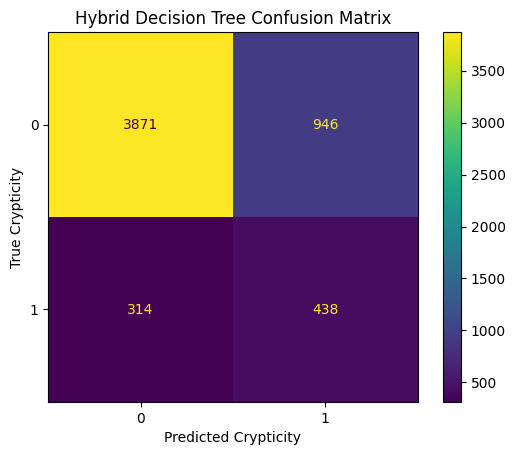

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("Hybrid Decision Tree Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/dt_hybrid_cm.png", dpi=210)

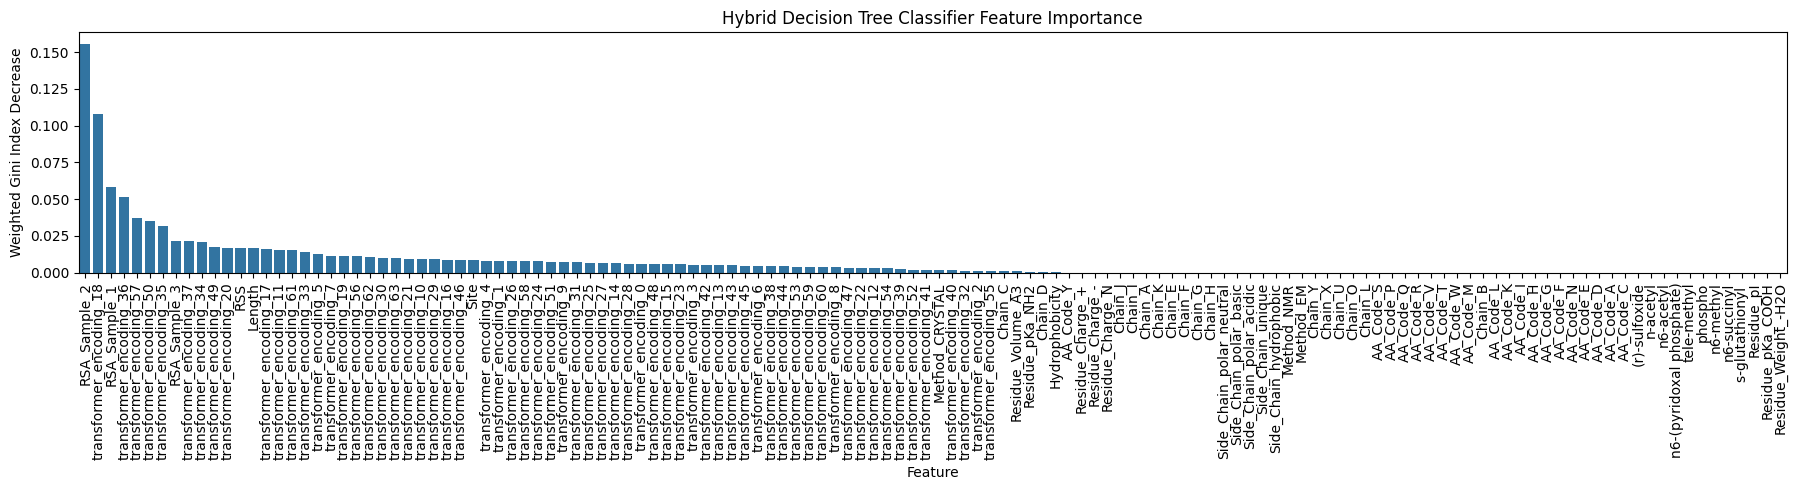

In [49]:
importances = dt_model.feature_importances_
all_feature_names = dt_model.feature_names_in_
indices = np.argsort(importances)[::-1]
importances = importances[indices]
all_feature_names = all_feature_names[indices]

fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
sns.barplot(x=all_feature_names, y=importances, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Weighted Gini Index Decrease")
ax.set_title("Hybrid Decision Tree Classifier Feature Importance")
plt.tight_layout()
fig.savefig('plots/dt_hybrid_builtin_feat_importance.png', dpi=210)

## Random Forest

In [22]:
rf_model = RandomForestClassifier(
  n_estimators=300,
  min_samples_split=20,
  min_samples_leaf=10,
  class_weight=class_weight,
  random_state=114514,
  n_jobs=-1,
  verbose=True
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest F1 Score:", f1_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s


Random Forest Accuracy: 0.8602980786496678
Random Forest F1 Score: 0.5


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    1.0s finished


In [25]:
with open('hybrid_rf_classifier.pickle', 'wb') as file:
  pickle.dump(rf_model, file)

In [26]:
X_test.to_csv("hybrid_rf_X_test.csv", index=False)

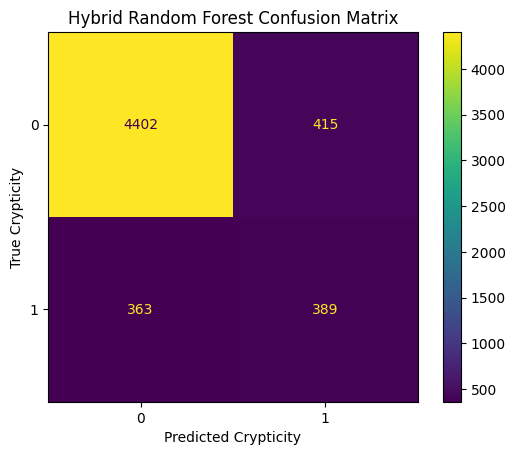

In [52]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_title("Hybrid Random Forest Confusion Matrix")
ax.set_xlabel('Predicted Crypticity')
ax.set_ylabel("True Crypticity")
fig.savefig("plots/rf_hybrid_cm.png", dpi=210)

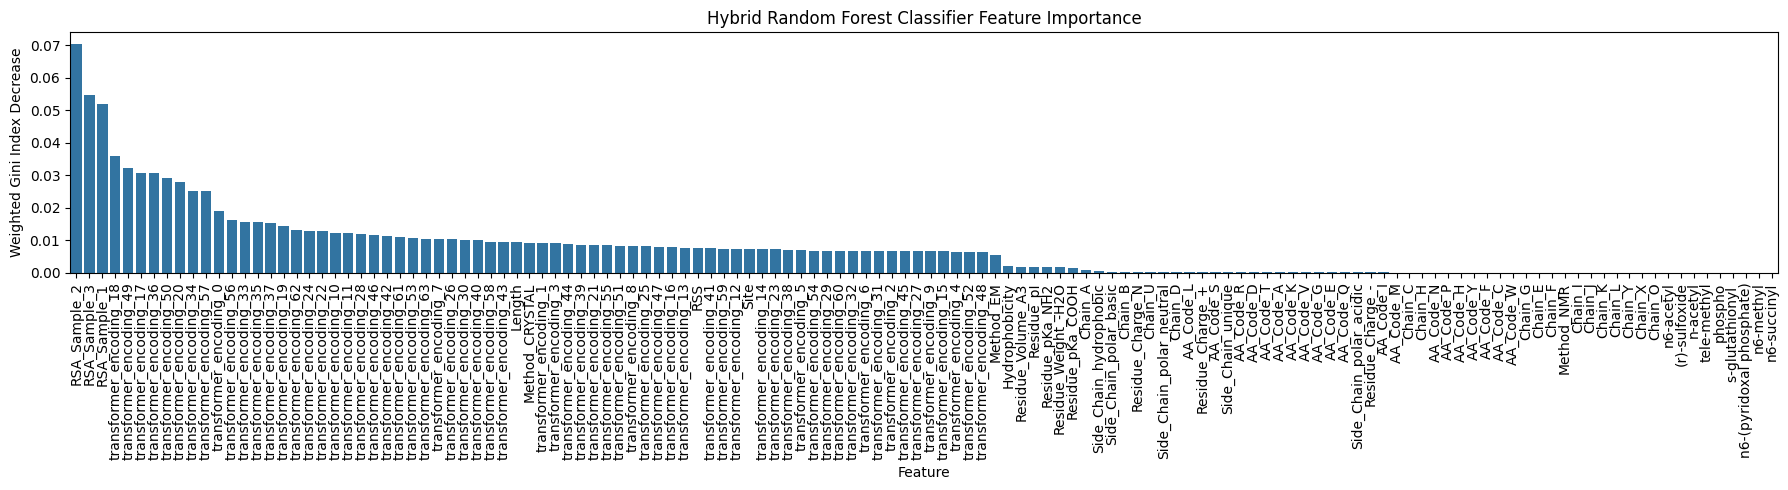

In [53]:
importances = rf_model.feature_importances_
all_feature_names = rf_model.feature_names_in_
indices = np.argsort(importances)[::-1]
importances = importances[indices]
all_feature_names = all_feature_names[indices]

fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
sns.barplot(x=all_feature_names, y=importances, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Weighted Gini Index Decrease")
ax.set_title("Hybrid Random Forest Classifier Feature Importance")
plt.tight_layout()
fig.savefig('plots/rf_hybrid_builtin_feat_importance.png', dpi=210)

# SHapley Additive exPlanations

In [47]:
with open('hybrid_rf_classifier.pickle', 'rb') as f:
  rf_model = pickle.load(f)
X_test = pd.read_csv('hybrid_rf_X_test.csv')
len(X_test)

5569

In [8]:
batch_size = 300
total_samples = X_test.shape[0]
num_batches = int(np.ceil(total_samples / batch_size))
explainer = shap.TreeExplainer(rf_model)

all_shap_values = []
for i in tqdm(range(num_batches), desc="Calculating SHAP Batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, total_samples)
    X_batch = X_test.iloc[start_idx:end_idx]
    shap_batch = explainer.shap_values(X_batch)
    all_shap_values.append(shap_batch)

Calculating SHAP Batches:   0%|          | 0/19 [00:00<?, ?it/s]

In [33]:
all_shap_values[0].shape

(300, 132, 2)

In [34]:
shap_values = np.concatenate(all_shap_values, axis=0)
shap_values.shape

(5569, 132, 2)

In [35]:
with open('shap.pickle', 'wb') as file:
  pickle.dump(shap_values, file)

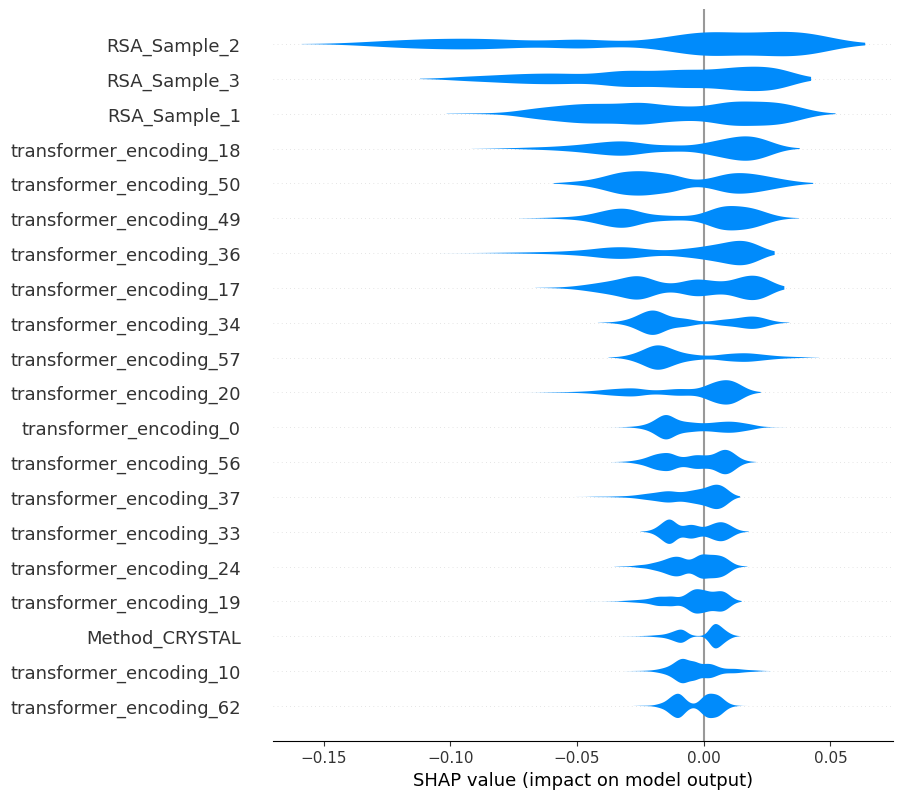

In [41]:
shap.plots.violin(shap_values[:,:,1], feature_names=X_test.columns)

In [44]:
shap_df = pd.DataFrame(shap_values[:,:,1], columns=X_test.columns)
shap_df.to_csv("shap_df_positive_category.csv", index=False)

In [5]:
shap_df = pd.read_csv("shap_df_positive_category.csv")
shap_df

,Hydrophobicity,Residue_Weight_-H2O,Residue_pKa_NH2,Residue_pKa_COOH,Residue_pI,Residue_Volume_A3,RSS,RSA_Sample_1,RSA_Sample_2,RSA_Sample_3,...,AA_Code_Q,AA_Code_R,AA_Code_S,AA_Code_T,AA_Code_V,AA_Code_W,AA_Code_Y,Residue_Charge_+,Residue_Charge_-,Residue_Charge_N
0,-0.000594,0.000208,0.000254,-0.000340,-0.000334,-0.000131,-0.009382,0.022915,0.031640,0.021287,...,-5.746975e-06,0.000059,-0.000310,-0.000046,0.000052,6.156608e-06,-0.000009,-5.705755e-07,-0.000011,-0.000053
1,-0.000204,-0.000053,-0.000220,-0.000223,-0.000142,-0.000670,0.000641,-0.021550,-0.043750,-0.031068,...,-5.566551e-05,0.000008,-0.000108,-0.000049,-0.000010,1.153520e-06,-0.000016,-3.263037e-05,-0.000014,-0.000018
2,0.000091,-0.000020,-0.000477,-0.000763,-0.000221,-0.000679,-0.001365,-0.020850,-0.073655,-0.040301,...,-6.470311e-05,0.000016,-0.000037,-0.000035,0.000007,5.954083e-06,-0.000021,4.539074e-04,-0.000011,-0.000094
3,-0.001130,-0.000831,-0.000221,-0.000426,-0.000610,-0.000609,-0.000017,-0.011533,0.003199,-0.008574,...,-2.643876e-05,0.000016,-0.000142,-0.000031,-0.000019,7.746390e-07,-0.000008,3.172012e-04,-0.000005,-0.000134
4,-0.000986,-0.001280,-0.000631,-0.000357,-0.000829,-0.000540,-0.001146,0.012993,0.021834,0.012113,...,-2.123641e-05,0.000021,-0.000129,-0.000065,0.000003,1.700494e-06,-0.000007,5.605158e-05,-0.000033,-0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,0.000034,0.000107,-0.000158,-0.000145,-0.000221,0.000474,0.001542,-0.040524,-0.100486,-0.062653,...,-2.812879e-05,0.000025,-0.000026,0.000004,0.000024,1.795587e-06,-0.000030,-2.169094e-04,-0.000002,0.000021
5565,-0.001875,-0.001988,-0.000861,-0.001298,-0.001444,-0.002624,-0.000575,0.006407,0.024053,0.012621,...,-3.200420e-05,0.000027,-0.000018,-0.000090,-0.000032,1.609677e-06,-0.000009,-9.115451e-05,-0.000111,0.000056
5566,0.001958,0.000503,0.000539,0.000431,0.000109,0.000609,-0.011917,-0.038156,-0.001651,-0.023517,...,1.977547e-05,0.000025,-0.000070,-0.000031,0.000030,1.852160e-06,-0.000007,-3.999554e-04,0.000006,0.000086
5567,-0.002666,-0.002994,-0.003121,-0.000837,-0.004304,-0.003021,-0.011963,-0.039871,-0.014792,-0.029154,...,-2.494634e-07,-0.001067,-0.000028,-0.000071,-0.000025,1.481748e-06,-0.000019,-3.299848e-05,0.000087,0.000061


In [11]:
for col in shap_df.columns:
  print(f'"{col}",')

"Hydrophobicity",
"Residue_Weight_-H2O",
"Residue_pKa_NH2",
"Residue_pKa_COOH",
"Residue_pI",
"Residue_Volume_A3",
"RSS",
"RSA_Sample_1",
"RSA_Sample_2",
"RSA_Sample_3",
"phospho",
"tele-methyl",
"n6-succinyl",
"n6-methyl",
"s-glutathionyl ",
"n6-(pyridoxal phosphate)",
"(r)-sulfoxide",
"n-acetyl",
"n6-acetyl",
"Site",
"Length",
"transformer_encoding_0",
"transformer_encoding_1",
"transformer_encoding_2",
"transformer_encoding_3",
"transformer_encoding_4",
"transformer_encoding_5",
"transformer_encoding_6",
"transformer_encoding_7",
"transformer_encoding_8",
"transformer_encoding_9",
"transformer_encoding_10",
"transformer_encoding_11",
"transformer_encoding_12",
"transformer_encoding_13",
"transformer_encoding_14",
"transformer_encoding_15",
"transformer_encoding_16",
"transformer_encoding_17",
"transformer_encoding_18",
"transformer_encoding_19",
"transformer_encoding_20",
"transformer_encoding_21",
"transformer_encoding_22",
"transformer_encoding_23",
"transformer_encoding_24",
"tra

In [12]:
res_chem_props = [
  "Hydrophobicity",
  "Residue_Weight_-H2O",
  "Residue_pKa_NH2",
  "Residue_pKa_COOH",
  "Residue_pI",
  "Residue_Volume_A3",
  "Side_Chain_hydrophobic",
  "Side_Chain_polar_acidic",
  "Side_Chain_polar_basic",
  "Side_Chain_polar_neutral",
  "Side_Chain_unique",
  "AA_Code_A",
  "AA_Code_C",
  "AA_Code_D",
  "AA_Code_E",
  "AA_Code_F",
  "AA_Code_G",
  "AA_Code_H",
  "AA_Code_I",
  "AA_Code_K",
  "AA_Code_L",
  "AA_Code_M",
  "AA_Code_N",
  "AA_Code_P",
  "AA_Code_Q",
  "AA_Code_R",
  "AA_Code_S",
  "AA_Code_T",
  "AA_Code_V",
  "AA_Code_W",
  "AA_Code_Y",
  "Residue_Charge_+",
  "Residue_Charge_-",
  "Residue_Charge_N",
]
evol_props = ['RSS']
expt_obs = [
  "RSA_Sample_1",
  "RSA_Sample_2",
  "RSA_Sample_3"
]
res_mods = [
  "phospho",
  "tele-methyl",
  "n6-succinyl",
  "n6-methyl",
  "s-glutathionyl ",
  "n6-(pyridoxal phosphate)",
  "(r)-sulfoxide",
  "n-acetyl",
  "n6-acetyl"
]
global_props = [
  "Site",
  "Length",
  "Chain_A",
  "Chain_B",
  "Chain_C",
  "Chain_D",
  "Chain_E",
  "Chain_F",
  "Chain_G",
  "Chain_H",
  "Chain_I",
  "Chain_J",
  "Chain_K",
  "Chain_L",
  "Chain_O",
  "Chain_U",
  "Chain_X",
  "Chain_Y",
  "Method_CRYSTAL",
  "Method_EM",
  "Method_NMR",
]
transformer = [
  "transformer_encoding_0",
  "transformer_encoding_1",
  "transformer_encoding_2",
  "transformer_encoding_3",
  "transformer_encoding_4",
  "transformer_encoding_5",
  "transformer_encoding_6",
  "transformer_encoding_7",
  "transformer_encoding_8",
  "transformer_encoding_9",
  "transformer_encoding_10",
  "transformer_encoding_11",
  "transformer_encoding_12",
  "transformer_encoding_13",
  "transformer_encoding_14",
  "transformer_encoding_15",
  "transformer_encoding_16",
  "transformer_encoding_17",
  "transformer_encoding_18",
  "transformer_encoding_19",
  "transformer_encoding_20",
  "transformer_encoding_21",
  "transformer_encoding_22",
  "transformer_encoding_23",
  "transformer_encoding_24",
  "transformer_encoding_25",
  "transformer_encoding_26",
  "transformer_encoding_27",
  "transformer_encoding_28",
  "transformer_encoding_29",
  "transformer_encoding_30",
  "transformer_encoding_31",
  "transformer_encoding_32",
  "transformer_encoding_33",
  "transformer_encoding_34",
  "transformer_encoding_35",
  "transformer_encoding_36",
  "transformer_encoding_37",
  "transformer_encoding_38",
  "transformer_encoding_39",
  "transformer_encoding_40",
  "transformer_encoding_41",
  "transformer_encoding_42",
  "transformer_encoding_43",
  "transformer_encoding_44",
  "transformer_encoding_45",
  "transformer_encoding_46",
  "transformer_encoding_47",
  "transformer_encoding_48",
  "transformer_encoding_49",
  "transformer_encoding_50",
  "transformer_encoding_51",
  "transformer_encoding_52",
  "transformer_encoding_53",
  "transformer_encoding_54",
  "transformer_encoding_55",
  "transformer_encoding_56",
  "transformer_encoding_57",
  "transformer_encoding_58",
  "transformer_encoding_59",
  "transformer_encoding_60",
  "transformer_encoding_61",
  "transformer_encoding_62",
  "transformer_encoding_63",
]

In [42]:
agg_feats = ['res_chem_props', 'evol_props', 'expt_obs', 'res_mods', 'global_props', 'transformer']
agg_cols = [res_chem_props, evol_props, expt_obs, res_mods, global_props, transformer]
agg_feats_abs = [agg_feat+"_abs" for agg_feat in agg_feats]
agg_feat_names = [
    'Residue Chemical Properties',
    'Evolutionary Conservation',
    'Experimental RSA Measurements',
    'Residue Modifications',
    'Global Protein Descriptors',
    'Transformer Encoding'
]

In [32]:
for agg_feat, agg_col in zip(agg_feats, agg_cols):
  shap_df[agg_feat] = shap_df[agg_col].mean(axis=1)
  shap_df[agg_feat+"_abs"] = shap_df[agg_col].map(np.abs).mean(axis=1)

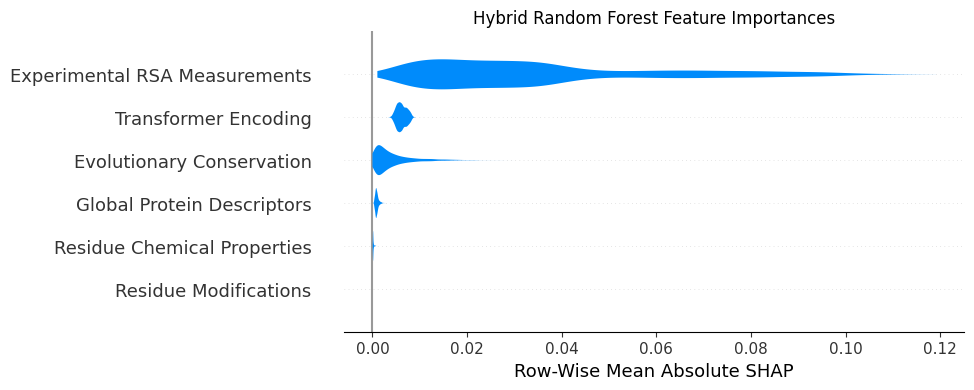

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
plt.sca(ax)
shap.plots.violin(shap_df[agg_feats_abs].to_numpy(), feature_names=agg_feat_names, show=False)
ax.set_xlabel('Row-Wise Mean Absolute SHAP')
ax.set_title("Hybrid Random Forest Feature Importances")
fig.savefig('plots/hybrid_rf_shap_violin.png', dpi=210, bbox_inches='tight')

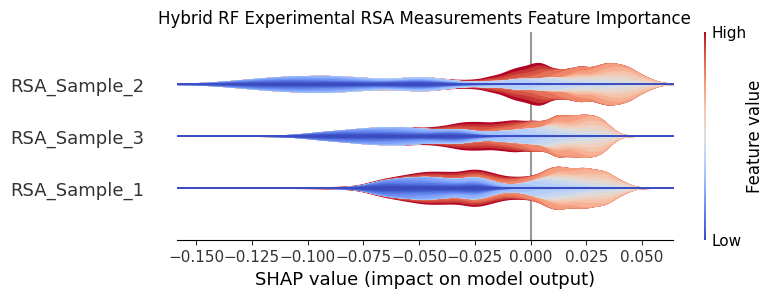

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
plt.sca(ax)
shap.plots.violin(shap_df[expt_obs].to_numpy(), features=X_test[expt_obs], feature_names=expt_obs, show=False, plot_type='layered_violin')
ax.set_title("Hybrid RF Experimental RSA Measurements Feature Importance")
fig.savefig('plots/hybrid_rf_rsa_violin.png', dpi=210, bbox_inches='tight')

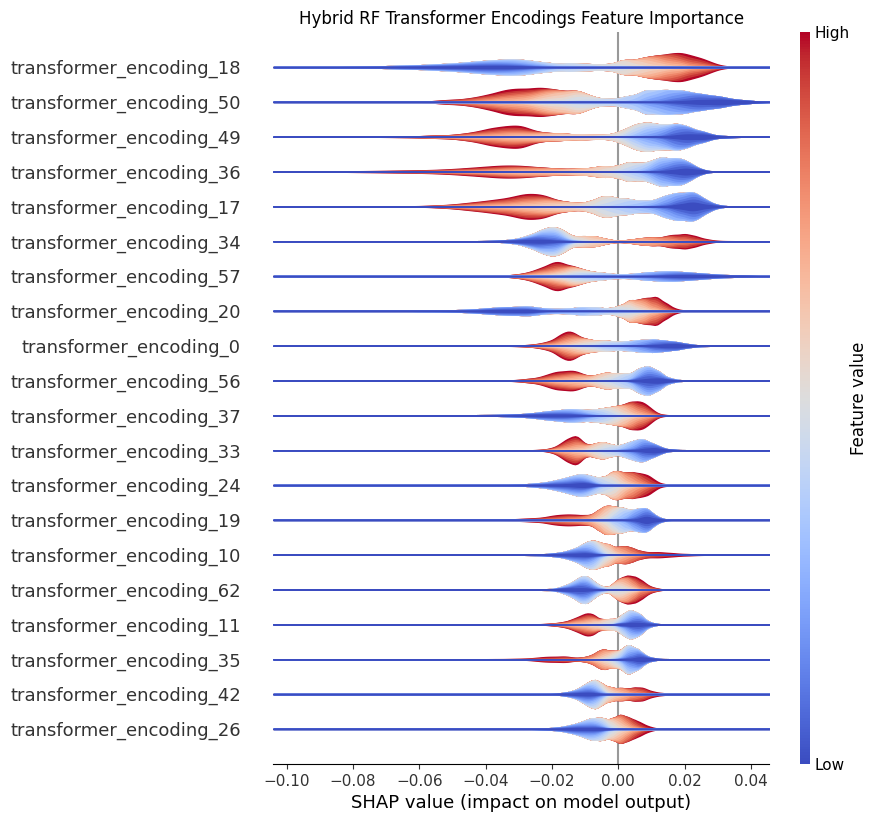

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 20)
plt.sca(ax)
shap.plots.violin(shap_df[transformer].to_numpy(), features=X_test[transformer], feature_names=transformer, show=False, plot_type='layered_violin')
ax.set_title("Hybrid RF Transformer Encodings Feature Importance")
fig.savefig('plots/hybrid_rf_transformer_shap_violin.png', dpi=210, bbox_inches='tight')

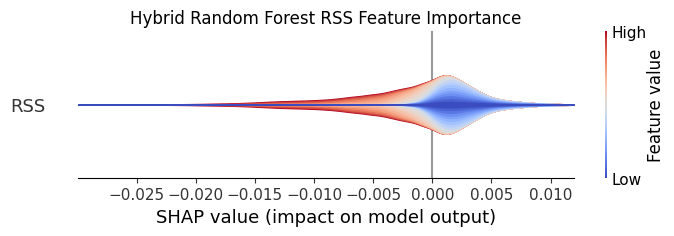

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
plt.sca(ax)
shap.plots.violin(shap_df[['RSS']].to_numpy(), features=X_test[['RSS']], feature_names='RSS', show=False, plot_type='layered_violin')
ax.set_yticks([0], ['RSS'])
ax.set_title("Hybrid Random Forest RSS Feature Importance")
fig.savefig('plots/hybrid_rf_rss_shap_violin.png', dpi=210, bbox_inches='tight')

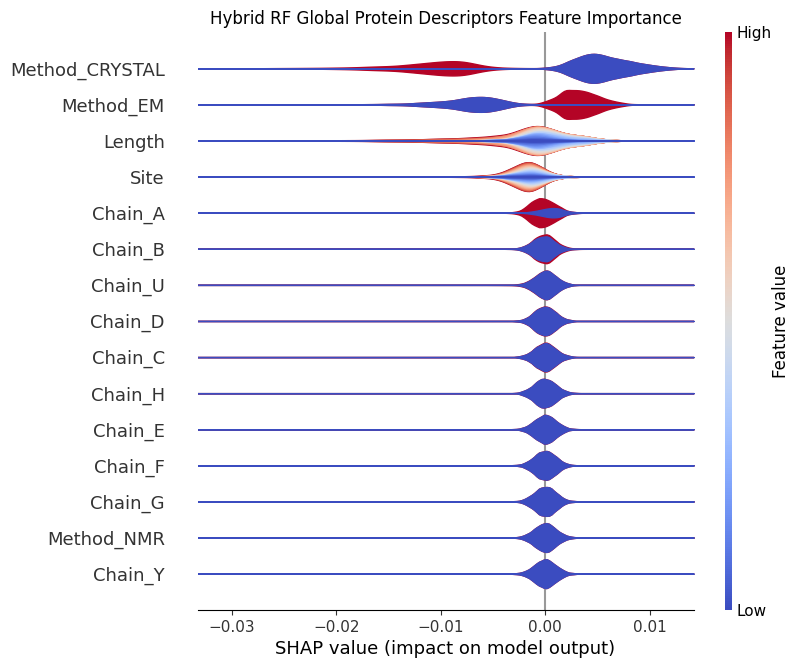

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 20)
plt.sca(ax)
varying_cols = [col for col in global_props if len(X_test[col].unique())>1]
shap.plots.violin(shap_df[varying_cols].to_numpy(), features=X_test[varying_cols], feature_names=varying_cols, show=False, plot_type='layered_violin')
ax.set_title("Hybrid RF Global Protein Descriptors Feature Importance")
fig.savefig('plots/hybrid_rf_global_shap_violin.png', dpi=210, bbox_inches='tight')

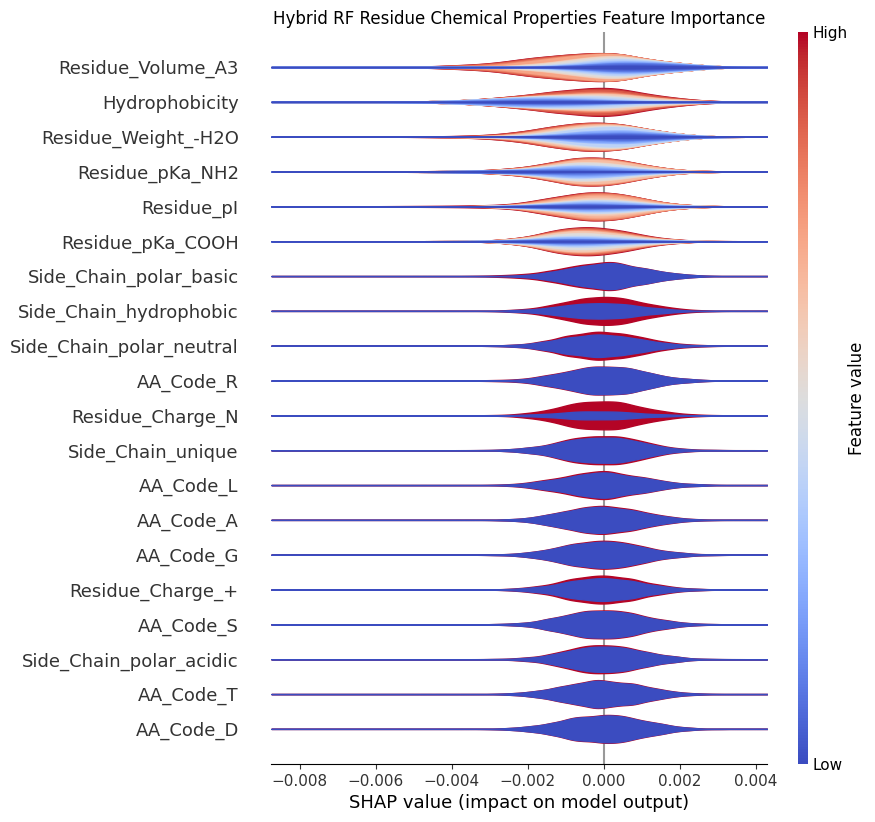

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 20)
plt.sca(ax)
shap.plots.violin(shap_df[res_chem_props].to_numpy(), features=X_test[res_chem_props], feature_names=res_chem_props, show=False, plot_type='layered_violin')
ax.set_title("Hybrid RF Residue Chemical Properties Feature Importance")
fig.savefig('plots/hybrid_rf_res_chem_shap_violin.png', dpi=210, bbox_inches='tight')

/usr/local/lib/python3.12/dist-packages/shap/plots/_violin.py:322: UserWarning: Not enough data in bin #1 for feature n6-methyl, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/plots/_violin.py:322: UserWarning: Not enough data in bin #1 for feature n-acetyl, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/plots/_violin.py:352: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(shap_min, shap_max)


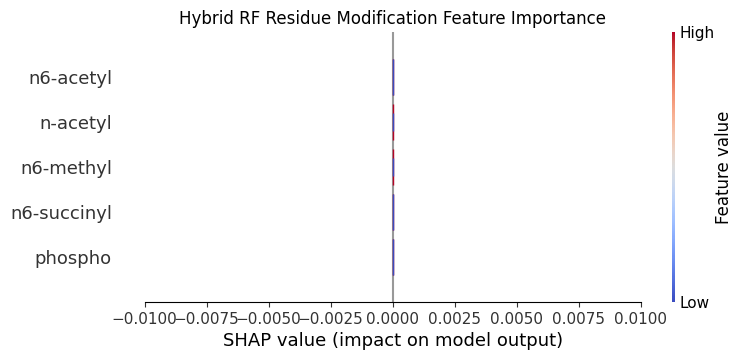

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
plt.sca(ax)
varying_cols = [col for col in res_mods if len(X_test[col].unique())>1]
shap.plots.violin(shap_df[varying_cols].to_numpy(), features=X_test[varying_cols], feature_names=varying_cols, show=False, plot_type='layered_violin')
ax.set_title("Hybrid RF Residue Modification Feature Importance")
ax.set_xlim(-0.01, 0.01)
fig.savefig('plots/hybrid_rf_res_mod_shap_violin.png', dpi=210, bbox_inches='tight')